# Atlas-level integration of lung data

An important task of single-cell analysis is the integration of several samples, which we can perform with scVI. For integration, scVI treats the data as unlabelled. When our dataset is fully labelled (perhaps in independent studies, or independent analysis pipelines), we can obtain an integration that better preserves biology using scANVI, which incorporates cell type annotation information. Here we demonstrate this functionality with an integrated analysis of cells from the lung atlas integration task from the [scIB manuscript](https://www.biorxiv.org/content/10.1101/2020.05.22.111161v2). The same pipeline would generally be used to analyze any collection of scRNA-seq datasets.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/env/lib/python3.11/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.0

```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

Note that this dataset has the counts already separated in a layer. Here, `adata.X` contains log transformed scran normalized expression.

In [5]:
adata_path = os.path.join(save_dir.name, "lung_atlas.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://figshare.com/ndownloader/files/24539942",
)
adata

  0%|          | 0.00/972M [00:00<?, ?B/s]

/env/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

### Dataset preprocessing

This dataset was already processed as described in the scIB manuscript. Generally, models in scvi-tools expect data that has been filtered/aggregated in the same fashion as one would do with Scanpy/Seurat.

Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate using all genes in terms of runtime, we usually recommend filtering genes for best integration performance. This will, among other things, remove batch-specific variation due to batch-specific gene expression.

We perform this gene selection using the Scanpy pipeline while keeping the full dimension normalized data in the `adata.raw` object. We obtain variable genes from each dataset and take their intersections.

In [6]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="batch",
    subset=True,
)

/env/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


```{important}
We see a warning about the data not containing counts. This is due to some of the samples in this dataset containing SoupX-corrected counts. scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts, and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.
```

## Integration with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:

- Register the AnnData object with the correct key to identify the sample and the layer key with the count data.
- Create an SCVI model object.

In [7]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


We note that these parameters are non-default; however, they have been verified to generally work well in the integration task.

In [8]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

Now we train scVI. This should take a couple of minutes on a Colab session

In [9]:
model.train()

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 1/246:   0%|          | 0/246 [00:00<?, ?it/s]

Epoch 1/246:   0%|          | 1/246 [00:01<06:22,  1.56s/it]

Epoch 1/246:   0%|          | 1/246 [00:01<06:22,  1.56s/it, v_num=1, train_loss_step=695, train_loss_epoch=738]

Epoch 2/246:   0%|          | 1/246 [00:01<06:22,  1.56s/it, v_num=1, train_loss_step=695, train_loss_epoch=738]

Epoch 2/246:   1%|          | 2/246 [00:02<05:09,  1.27s/it, v_num=1, train_loss_step=695, train_loss_epoch=738]

Epoch 2/246:   1%|          | 2/246 [00:02<05:09,  1.27s/it, v_num=1, train_loss_step=650, train_loss_epoch=656]

Epoch 3/246:   1%|          | 2/246 [00:02<05:09,  1.27s/it, v_num=1, train_loss_step=650, train_loss_epoch=656]

Epoch 3/246:   1%|          | 3/246 [00:03<04:44,  1.17s/it, v_num=1, train_loss_step=650, train_loss_epoch=656]

Epoch 3/246:   1%|          | 3/246 [00:03<04:44,  1.17s/it, v_num=1, train_loss_step=610, train_loss_epoch=637]

Epoch 4/246:   1%|          | 3/246 [00:03<04:44,  1.17s/it, v_num=1, train_loss_step=610, train_loss_epoch=637]

Epoch 4/246:   2%|▏         | 4/246 [00:04<04:32,  1.13s/it, v_num=1, train_loss_step=610, train_loss_epoch=637]

Epoch 4/246:   2%|▏         | 4/246 [00:04<04:32,  1.13s/it, v_num=1, train_loss_step=627, train_loss_epoch=624]

Epoch 5/246:   2%|▏         | 4/246 [00:04<04:32,  1.13s/it, v_num=1, train_loss_step=627, train_loss_epoch=624]

Epoch 5/246:   2%|▏         | 5/246 [00:05<04:25,  1.10s/it, v_num=1, train_loss_step=627, train_loss_epoch=624]

Epoch 5/246:   2%|▏         | 5/246 [00:05<04:25,  1.10s/it, v_num=1, train_loss_step=589, train_loss_epoch=614]

Epoch 6/246:   2%|▏         | 5/246 [00:05<04:25,  1.10s/it, v_num=1, train_loss_step=589, train_loss_epoch=614]

Epoch 6/246:   2%|▏         | 6/246 [00:06<04:21,  1.09s/it, v_num=1, train_loss_step=589, train_loss_epoch=614]

Epoch 6/246:   2%|▏         | 6/246 [00:06<04:21,  1.09s/it, v_num=1, train_loss_step=583, train_loss_epoch=606]

Epoch 7/246:   2%|▏         | 6/246 [00:06<04:21,  1.09s/it, v_num=1, train_loss_step=583, train_loss_epoch=606]

Epoch 7/246:   3%|▎         | 7/246 [00:07<04:17,  1.08s/it, v_num=1, train_loss_step=583, train_loss_epoch=606]

Epoch 7/246:   3%|▎         | 7/246 [00:07<04:17,  1.08s/it, v_num=1, train_loss_step=601, train_loss_epoch=599]

Epoch 8/246:   3%|▎         | 7/246 [00:07<04:17,  1.08s/it, v_num=1, train_loss_step=601, train_loss_epoch=599]

Epoch 8/246:   3%|▎         | 8/246 [00:08<04:15,  1.07s/it, v_num=1, train_loss_step=601, train_loss_epoch=599]

Epoch 8/246:   3%|▎         | 8/246 [00:08<04:15,  1.07s/it, v_num=1, train_loss_step=606, train_loss_epoch=593]

Epoch 9/246:   3%|▎         | 8/246 [00:08<04:15,  1.07s/it, v_num=1, train_loss_step=606, train_loss_epoch=593]

Epoch 9/246:   4%|▎         | 9/246 [00:10<04:13,  1.07s/it, v_num=1, train_loss_step=606, train_loss_epoch=593]

Epoch 9/246:   4%|▎         | 9/246 [00:10<04:13,  1.07s/it, v_num=1, train_loss_step=575, train_loss_epoch=587]

Epoch 10/246:   4%|▎         | 9/246 [00:10<04:13,  1.07s/it, v_num=1, train_loss_step=575, train_loss_epoch=587]

Epoch 10/246:   4%|▍         | 10/246 [00:11<04:11,  1.07s/it, v_num=1, train_loss_step=575, train_loss_epoch=587]

Epoch 10/246:   4%|▍         | 10/246 [00:11<04:11,  1.07s/it, v_num=1, train_loss_step=581, train_loss_epoch=583]

Epoch 11/246:   4%|▍         | 10/246 [00:11<04:11,  1.07s/it, v_num=1, train_loss_step=581, train_loss_epoch=583]

Epoch 11/246:   4%|▍         | 11/246 [00:12<04:10,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=583]

Epoch 11/246:   4%|▍         | 11/246 [00:12<04:10,  1.06s/it, v_num=1, train_loss_step=610, train_loss_epoch=579]

Epoch 12/246:   4%|▍         | 11/246 [00:12<04:10,  1.06s/it, v_num=1, train_loss_step=610, train_loss_epoch=579]

Epoch 12/246:   5%|▍         | 12/246 [00:13<04:08,  1.06s/it, v_num=1, train_loss_step=610, train_loss_epoch=579]

Epoch 12/246:   5%|▍         | 12/246 [00:13<04:08,  1.06s/it, v_num=1, train_loss_step=542, train_loss_epoch=576]

Epoch 13/246:   5%|▍         | 12/246 [00:13<04:08,  1.06s/it, v_num=1, train_loss_step=542, train_loss_epoch=576]

Epoch 13/246:   5%|▌         | 13/246 [00:14<04:07,  1.06s/it, v_num=1, train_loss_step=542, train_loss_epoch=576]

Epoch 13/246:   5%|▌         | 13/246 [00:14<04:07,  1.06s/it, v_num=1, train_loss_step=577, train_loss_epoch=572]

Epoch 14/246:   5%|▌         | 13/246 [00:14<04:07,  1.06s/it, v_num=1, train_loss_step=577, train_loss_epoch=572]

Epoch 14/246:   6%|▌         | 14/246 [00:15<04:06,  1.06s/it, v_num=1, train_loss_step=577, train_loss_epoch=572]

Epoch 14/246:   6%|▌         | 14/246 [00:15<04:06,  1.06s/it, v_num=1, train_loss_step=495, train_loss_epoch=570]

Epoch 15/246:   6%|▌         | 14/246 [00:15<04:06,  1.06s/it, v_num=1, train_loss_step=495, train_loss_epoch=570]

Epoch 15/246:   6%|▌         | 15/246 [00:16<04:05,  1.06s/it, v_num=1, train_loss_step=495, train_loss_epoch=570]

Epoch 15/246:   6%|▌         | 15/246 [00:16<04:05,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=567]

Epoch 16/246:   6%|▌         | 15/246 [00:16<04:05,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=567]

Epoch 16/246:   7%|▋         | 16/246 [00:17<04:04,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=567]

Epoch 16/246:   7%|▋         | 16/246 [00:17<04:04,  1.06s/it, v_num=1, train_loss_step=606, train_loss_epoch=565]

Epoch 17/246:   7%|▋         | 16/246 [00:17<04:04,  1.06s/it, v_num=1, train_loss_step=606, train_loss_epoch=565]

Epoch 17/246:   7%|▋         | 17/246 [00:18<04:03,  1.06s/it, v_num=1, train_loss_step=606, train_loss_epoch=565]

Epoch 17/246:   7%|▋         | 17/246 [00:18<04:03,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=563]

Epoch 18/246:   7%|▋         | 17/246 [00:18<04:03,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=563]

Epoch 18/246:   7%|▋         | 18/246 [00:19<04:02,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=563]

Epoch 18/246:   7%|▋         | 18/246 [00:19<04:02,  1.06s/it, v_num=1, train_loss_step=571, train_loss_epoch=562]

Epoch 19/246:   7%|▋         | 18/246 [00:19<04:02,  1.06s/it, v_num=1, train_loss_step=571, train_loss_epoch=562]

Epoch 19/246:   8%|▊         | 19/246 [00:20<04:00,  1.06s/it, v_num=1, train_loss_step=571, train_loss_epoch=562]

Epoch 19/246:   8%|▊         | 19/246 [00:20<04:00,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=560]

Epoch 20/246:   8%|▊         | 19/246 [00:20<04:00,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=560]

Epoch 20/246:   8%|▊         | 20/246 [00:21<03:59,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=560]

Epoch 20/246:   8%|▊         | 20/246 [00:21<03:59,  1.06s/it, v_num=1, train_loss_step=572, train_loss_epoch=559]

Epoch 21/246:   8%|▊         | 20/246 [00:21<03:59,  1.06s/it, v_num=1, train_loss_step=572, train_loss_epoch=559]

Epoch 21/246:   9%|▊         | 21/246 [00:22<03:58,  1.06s/it, v_num=1, train_loss_step=572, train_loss_epoch=559]

Epoch 21/246:   9%|▊         | 21/246 [00:22<03:58,  1.06s/it, v_num=1, train_loss_step=605, train_loss_epoch=558]

Epoch 22/246:   9%|▊         | 21/246 [00:22<03:58,  1.06s/it, v_num=1, train_loss_step=605, train_loss_epoch=558]

Epoch 22/246:   9%|▉         | 22/246 [00:23<03:57,  1.06s/it, v_num=1, train_loss_step=605, train_loss_epoch=558]

Epoch 22/246:   9%|▉         | 22/246 [00:23<03:57,  1.06s/it, v_num=1, train_loss_step=585, train_loss_epoch=557]

Epoch 23/246:   9%|▉         | 22/246 [00:23<03:57,  1.06s/it, v_num=1, train_loss_step=585, train_loss_epoch=557]

Epoch 23/246:   9%|▉         | 23/246 [00:24<03:56,  1.06s/it, v_num=1, train_loss_step=585, train_loss_epoch=557]

Epoch 23/246:   9%|▉         | 23/246 [00:24<03:56,  1.06s/it, v_num=1, train_loss_step=486, train_loss_epoch=556]

Epoch 24/246:   9%|▉         | 23/246 [00:24<03:56,  1.06s/it, v_num=1, train_loss_step=486, train_loss_epoch=556]

Epoch 24/246:  10%|▉         | 24/246 [00:25<03:57,  1.07s/it, v_num=1, train_loss_step=486, train_loss_epoch=556]

Epoch 24/246:  10%|▉         | 24/246 [00:25<03:57,  1.07s/it, v_num=1, train_loss_step=542, train_loss_epoch=555]

Epoch 25/246:  10%|▉         | 24/246 [00:25<03:57,  1.07s/it, v_num=1, train_loss_step=542, train_loss_epoch=555]

Epoch 25/246:  10%|█         | 25/246 [00:27<03:55,  1.07s/it, v_num=1, train_loss_step=542, train_loss_epoch=555]

Epoch 25/246:  10%|█         | 25/246 [00:27<03:55,  1.07s/it, v_num=1, train_loss_step=529, train_loss_epoch=554]

Epoch 26/246:  10%|█         | 25/246 [00:27<03:55,  1.07s/it, v_num=1, train_loss_step=529, train_loss_epoch=554]

Epoch 26/246:  11%|█         | 26/246 [00:28<03:54,  1.06s/it, v_num=1, train_loss_step=529, train_loss_epoch=554]

Epoch 26/246:  11%|█         | 26/246 [00:28<03:54,  1.06s/it, v_num=1, train_loss_step=609, train_loss_epoch=554]

Epoch 27/246:  11%|█         | 26/246 [00:28<03:54,  1.06s/it, v_num=1, train_loss_step=609, train_loss_epoch=554]

Epoch 27/246:  11%|█         | 27/246 [00:29<03:52,  1.06s/it, v_num=1, train_loss_step=609, train_loss_epoch=554]

Epoch 27/246:  11%|█         | 27/246 [00:29<03:52,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=553]

Epoch 28/246:  11%|█         | 27/246 [00:29<03:52,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=553]

Epoch 28/246:  11%|█▏        | 28/246 [00:30<03:51,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=553]

Epoch 28/246:  11%|█▏        | 28/246 [00:30<03:51,  1.06s/it, v_num=1, train_loss_step=545, train_loss_epoch=552]

Epoch 29/246:  11%|█▏        | 28/246 [00:30<03:51,  1.06s/it, v_num=1, train_loss_step=545, train_loss_epoch=552]

Epoch 29/246:  12%|█▏        | 29/246 [00:31<03:50,  1.06s/it, v_num=1, train_loss_step=545, train_loss_epoch=552]

Epoch 29/246:  12%|█▏        | 29/246 [00:31<03:50,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]

Epoch 30/246:  12%|█▏        | 29/246 [00:31<03:50,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]

Epoch 30/246:  12%|█▏        | 30/246 [00:32<03:49,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]

Epoch 30/246:  12%|█▏        | 30/246 [00:32<03:49,  1.06s/it, v_num=1, train_loss_step=546, train_loss_epoch=551]

Epoch 31/246:  12%|█▏        | 30/246 [00:32<03:49,  1.06s/it, v_num=1, train_loss_step=546, train_loss_epoch=551]

Epoch 31/246:  13%|█▎        | 31/246 [00:33<03:48,  1.06s/it, v_num=1, train_loss_step=546, train_loss_epoch=551]

Epoch 31/246:  13%|█▎        | 31/246 [00:33<03:48,  1.06s/it, v_num=1, train_loss_step=569, train_loss_epoch=551]

Epoch 32/246:  13%|█▎        | 31/246 [00:33<03:48,  1.06s/it, v_num=1, train_loss_step=569, train_loss_epoch=551]

Epoch 32/246:  13%|█▎        | 32/246 [00:34<03:47,  1.06s/it, v_num=1, train_loss_step=569, train_loss_epoch=551]

Epoch 32/246:  13%|█▎        | 32/246 [00:34<03:47,  1.06s/it, v_num=1, train_loss_step=624, train_loss_epoch=551]

Epoch 33/246:  13%|█▎        | 32/246 [00:34<03:47,  1.06s/it, v_num=1, train_loss_step=624, train_loss_epoch=551]

Epoch 33/246:  13%|█▎        | 33/246 [00:35<03:45,  1.06s/it, v_num=1, train_loss_step=624, train_loss_epoch=551]

Epoch 33/246:  13%|█▎        | 33/246 [00:35<03:45,  1.06s/it, v_num=1, train_loss_step=561, train_loss_epoch=550]

Epoch 34/246:  13%|█▎        | 33/246 [00:35<03:45,  1.06s/it, v_num=1, train_loss_step=561, train_loss_epoch=550]

Epoch 34/246:  14%|█▍        | 34/246 [00:36<03:44,  1.06s/it, v_num=1, train_loss_step=561, train_loss_epoch=550]

Epoch 34/246:  14%|█▍        | 34/246 [00:36<03:44,  1.06s/it, v_num=1, train_loss_step=583, train_loss_epoch=550]

Epoch 35/246:  14%|█▍        | 34/246 [00:36<03:44,  1.06s/it, v_num=1, train_loss_step=583, train_loss_epoch=550]

Epoch 35/246:  14%|█▍        | 35/246 [00:37<03:43,  1.06s/it, v_num=1, train_loss_step=583, train_loss_epoch=550]

Epoch 35/246:  14%|█▍        | 35/246 [00:37<03:43,  1.06s/it, v_num=1, train_loss_step=542, train_loss_epoch=549]

Epoch 36/246:  14%|█▍        | 35/246 [00:37<03:43,  1.06s/it, v_num=1, train_loss_step=542, train_loss_epoch=549]

Epoch 36/246:  15%|█▍        | 36/246 [00:38<03:42,  1.06s/it, v_num=1, train_loss_step=542, train_loss_epoch=549]

Epoch 36/246:  15%|█▍        | 36/246 [00:38<03:42,  1.06s/it, v_num=1, train_loss_step=585, train_loss_epoch=549]

Epoch 37/246:  15%|█▍        | 36/246 [00:38<03:42,  1.06s/it, v_num=1, train_loss_step=585, train_loss_epoch=549]

Epoch 37/246:  15%|█▌        | 37/246 [00:39<03:41,  1.06s/it, v_num=1, train_loss_step=585, train_loss_epoch=549]

Epoch 37/246:  15%|█▌        | 37/246 [00:39<03:41,  1.06s/it, v_num=1, train_loss_step=549, train_loss_epoch=549]

Epoch 38/246:  15%|█▌        | 37/246 [00:39<03:41,  1.06s/it, v_num=1, train_loss_step=549, train_loss_epoch=549]

Epoch 38/246:  15%|█▌        | 38/246 [00:40<03:40,  1.06s/it, v_num=1, train_loss_step=549, train_loss_epoch=549]

Epoch 38/246:  15%|█▌        | 38/246 [00:40<03:40,  1.06s/it, v_num=1, train_loss_step=553, train_loss_epoch=549]

Epoch 39/246:  15%|█▌        | 38/246 [00:40<03:40,  1.06s/it, v_num=1, train_loss_step=553, train_loss_epoch=549]

Epoch 39/246:  16%|█▌        | 39/246 [00:41<03:39,  1.06s/it, v_num=1, train_loss_step=553, train_loss_epoch=549]

Epoch 39/246:  16%|█▌        | 39/246 [00:41<03:39,  1.06s/it, v_num=1, train_loss_step=546, train_loss_epoch=549]

Epoch 40/246:  16%|█▌        | 39/246 [00:41<03:39,  1.06s/it, v_num=1, train_loss_step=546, train_loss_epoch=549]

Epoch 40/246:  16%|█▋        | 40/246 [00:42<03:38,  1.06s/it, v_num=1, train_loss_step=546, train_loss_epoch=549]

Epoch 40/246:  16%|█▋        | 40/246 [00:42<03:38,  1.06s/it, v_num=1, train_loss_step=566, train_loss_epoch=548]

Epoch 41/246:  16%|█▋        | 40/246 [00:42<03:38,  1.06s/it, v_num=1, train_loss_step=566, train_loss_epoch=548]

Epoch 41/246:  17%|█▋        | 41/246 [00:43<03:37,  1.06s/it, v_num=1, train_loss_step=566, train_loss_epoch=548]

Epoch 41/246:  17%|█▋        | 41/246 [00:43<03:37,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]

Epoch 42/246:  17%|█▋        | 41/246 [00:44<03:37,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]

Epoch 42/246:  17%|█▋        | 42/246 [00:45<03:35,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]

Epoch 42/246:  17%|█▋        | 42/246 [00:45<03:35,  1.06s/it, v_num=1, train_loss_step=596, train_loss_epoch=548]

Epoch 43/246:  17%|█▋        | 42/246 [00:45<03:35,  1.06s/it, v_num=1, train_loss_step=596, train_loss_epoch=548]

Epoch 43/246:  17%|█▋        | 43/246 [00:46<03:33,  1.05s/it, v_num=1, train_loss_step=596, train_loss_epoch=548]

Epoch 43/246:  17%|█▋        | 43/246 [00:46<03:33,  1.05s/it, v_num=1, train_loss_step=605, train_loss_epoch=548]

Epoch 44/246:  17%|█▋        | 43/246 [00:46<03:33,  1.05s/it, v_num=1, train_loss_step=605, train_loss_epoch=548]

Epoch 44/246:  18%|█▊        | 44/246 [00:47<03:32,  1.05s/it, v_num=1, train_loss_step=605, train_loss_epoch=548]

Epoch 44/246:  18%|█▊        | 44/246 [00:47<03:32,  1.05s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]

Epoch 45/246:  18%|█▊        | 44/246 [00:47<03:32,  1.05s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]

Epoch 45/246:  18%|█▊        | 45/246 [00:48<03:32,  1.06s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]

Epoch 45/246:  18%|█▊        | 45/246 [00:48<03:32,  1.06s/it, v_num=1, train_loss_step=556, train_loss_epoch=548]

Epoch 46/246:  18%|█▊        | 45/246 [00:48<03:32,  1.06s/it, v_num=1, train_loss_step=556, train_loss_epoch=548]

Epoch 46/246:  19%|█▊        | 46/246 [00:49<03:31,  1.06s/it, v_num=1, train_loss_step=556, train_loss_epoch=548]

Epoch 46/246:  19%|█▊        | 46/246 [00:49<03:31,  1.06s/it, v_num=1, train_loss_step=572, train_loss_epoch=548]

Epoch 47/246:  19%|█▊        | 46/246 [00:49<03:31,  1.06s/it, v_num=1, train_loss_step=572, train_loss_epoch=548]

Epoch 47/246:  19%|█▉        | 47/246 [00:50<03:30,  1.06s/it, v_num=1, train_loss_step=572, train_loss_epoch=548]

Epoch 47/246:  19%|█▉        | 47/246 [00:50<03:30,  1.06s/it, v_num=1, train_loss_step=552, train_loss_epoch=548]

Epoch 48/246:  19%|█▉        | 47/246 [00:50<03:30,  1.06s/it, v_num=1, train_loss_step=552, train_loss_epoch=548]

Epoch 48/246:  20%|█▉        | 48/246 [00:51<03:29,  1.06s/it, v_num=1, train_loss_step=552, train_loss_epoch=548]

Epoch 48/246:  20%|█▉        | 48/246 [00:51<03:29,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]

Epoch 49/246:  20%|█▉        | 48/246 [00:51<03:29,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]

Epoch 49/246:  20%|█▉        | 49/246 [00:52<03:28,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]

Epoch 49/246:  20%|█▉        | 49/246 [00:52<03:28,  1.06s/it, v_num=1, train_loss_step=547, train_loss_epoch=547]

Epoch 50/246:  20%|█▉        | 49/246 [00:52<03:28,  1.06s/it, v_num=1, train_loss_step=547, train_loss_epoch=547]

Epoch 50/246:  20%|██        | 50/246 [00:53<03:27,  1.06s/it, v_num=1, train_loss_step=547, train_loss_epoch=547]

Epoch 50/246:  20%|██        | 50/246 [00:53<03:27,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=547]

Epoch 51/246:  20%|██        | 50/246 [00:53<03:27,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=547]

Epoch 51/246:  21%|██        | 51/246 [00:54<03:26,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=547]

Epoch 51/246:  21%|██        | 51/246 [00:54<03:26,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=547]

Epoch 52/246:  21%|██        | 51/246 [00:54<03:26,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=547]

Epoch 52/246:  21%|██        | 52/246 [00:55<03:25,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=547]

Epoch 52/246:  21%|██        | 52/246 [00:55<03:25,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=547]

Epoch 53/246:  21%|██        | 52/246 [00:55<03:25,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=547]

Epoch 53/246:  22%|██▏       | 53/246 [00:56<03:24,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=547]

Epoch 53/246:  22%|██▏       | 53/246 [00:56<03:24,  1.06s/it, v_num=1, train_loss_step=556, train_loss_epoch=547]

Epoch 54/246:  22%|██▏       | 53/246 [00:56<03:24,  1.06s/it, v_num=1, train_loss_step=556, train_loss_epoch=547]

Epoch 54/246:  22%|██▏       | 54/246 [00:57<03:23,  1.06s/it, v_num=1, train_loss_step=556, train_loss_epoch=547]

Epoch 54/246:  22%|██▏       | 54/246 [00:57<03:23,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=547]

Epoch 55/246:  22%|██▏       | 54/246 [00:57<03:23,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=547]

Epoch 55/246:  22%|██▏       | 55/246 [00:58<03:22,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=547]

Epoch 55/246:  22%|██▏       | 55/246 [00:58<03:22,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=547]

Epoch 56/246:  22%|██▏       | 55/246 [00:58<03:22,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=547]

Epoch 56/246:  23%|██▎       | 56/246 [00:59<03:21,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=547]

Epoch 56/246:  23%|██▎       | 56/246 [00:59<03:21,  1.06s/it, v_num=1, train_loss_step=558, train_loss_epoch=547]

Epoch 57/246:  23%|██▎       | 56/246 [00:59<03:21,  1.06s/it, v_num=1, train_loss_step=558, train_loss_epoch=547]

Epoch 57/246:  23%|██▎       | 57/246 [01:00<03:20,  1.06s/it, v_num=1, train_loss_step=558, train_loss_epoch=547]

Epoch 57/246:  23%|██▎       | 57/246 [01:00<03:20,  1.06s/it, v_num=1, train_loss_step=585, train_loss_epoch=547]

Epoch 58/246:  23%|██▎       | 57/246 [01:00<03:20,  1.06s/it, v_num=1, train_loss_step=585, train_loss_epoch=547]

Epoch 58/246:  24%|██▎       | 58/246 [01:02<03:19,  1.06s/it, v_num=1, train_loss_step=585, train_loss_epoch=547]

Epoch 58/246:  24%|██▎       | 58/246 [01:02<03:19,  1.06s/it, v_num=1, train_loss_step=531, train_loss_epoch=547]

Epoch 59/246:  24%|██▎       | 58/246 [01:02<03:19,  1.06s/it, v_num=1, train_loss_step=531, train_loss_epoch=547]

Epoch 59/246:  24%|██▍       | 59/246 [01:03<03:18,  1.06s/it, v_num=1, train_loss_step=531, train_loss_epoch=547]

Epoch 59/246:  24%|██▍       | 59/246 [01:03<03:18,  1.06s/it, v_num=1, train_loss_step=548, train_loss_epoch=547]

Epoch 60/246:  24%|██▍       | 59/246 [01:03<03:18,  1.06s/it, v_num=1, train_loss_step=548, train_loss_epoch=547]

Epoch 60/246:  24%|██▍       | 60/246 [01:04<03:17,  1.06s/it, v_num=1, train_loss_step=548, train_loss_epoch=547]

Epoch 60/246:  24%|██▍       | 60/246 [01:04<03:17,  1.06s/it, v_num=1, train_loss_step=549, train_loss_epoch=547]

Epoch 61/246:  24%|██▍       | 60/246 [01:04<03:17,  1.06s/it, v_num=1, train_loss_step=549, train_loss_epoch=547]

Epoch 61/246:  25%|██▍       | 61/246 [01:05<03:16,  1.06s/it, v_num=1, train_loss_step=549, train_loss_epoch=547]

Epoch 61/246:  25%|██▍       | 61/246 [01:05<03:16,  1.06s/it, v_num=1, train_loss_step=586, train_loss_epoch=547]

Epoch 62/246:  25%|██▍       | 61/246 [01:05<03:16,  1.06s/it, v_num=1, train_loss_step=586, train_loss_epoch=547]

Epoch 62/246:  25%|██▌       | 62/246 [01:06<03:15,  1.06s/it, v_num=1, train_loss_step=586, train_loss_epoch=547]

Epoch 62/246:  25%|██▌       | 62/246 [01:06<03:15,  1.06s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]

Epoch 63/246:  25%|██▌       | 62/246 [01:06<03:15,  1.06s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]

Epoch 63/246:  26%|██▌       | 63/246 [01:07<03:14,  1.06s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]

Epoch 63/246:  26%|██▌       | 63/246 [01:07<03:14,  1.06s/it, v_num=1, train_loss_step=554, train_loss_epoch=547]

Epoch 64/246:  26%|██▌       | 63/246 [01:07<03:14,  1.06s/it, v_num=1, train_loss_step=554, train_loss_epoch=547]

Epoch 64/246:  26%|██▌       | 64/246 [01:08<03:13,  1.06s/it, v_num=1, train_loss_step=554, train_loss_epoch=547]

Epoch 64/246:  26%|██▌       | 64/246 [01:08<03:13,  1.06s/it, v_num=1, train_loss_step=553, train_loss_epoch=547]

Epoch 65/246:  26%|██▌       | 64/246 [01:08<03:13,  1.06s/it, v_num=1, train_loss_step=553, train_loss_epoch=547]

Epoch 65/246:  26%|██▋       | 65/246 [01:09<03:12,  1.06s/it, v_num=1, train_loss_step=553, train_loss_epoch=547]

Epoch 65/246:  26%|██▋       | 65/246 [01:09<03:12,  1.06s/it, v_num=1, train_loss_step=497, train_loss_epoch=547]

Epoch 66/246:  26%|██▋       | 65/246 [01:09<03:12,  1.06s/it, v_num=1, train_loss_step=497, train_loss_epoch=547]

Epoch 66/246:  27%|██▋       | 66/246 [01:10<03:11,  1.06s/it, v_num=1, train_loss_step=497, train_loss_epoch=547]

Epoch 66/246:  27%|██▋       | 66/246 [01:10<03:11,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=547]

Epoch 67/246:  27%|██▋       | 66/246 [01:10<03:11,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=547]

Epoch 67/246:  27%|██▋       | 67/246 [01:11<03:10,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=547]

Epoch 67/246:  27%|██▋       | 67/246 [01:11<03:10,  1.06s/it, v_num=1, train_loss_step=543, train_loss_epoch=547]

Epoch 68/246:  27%|██▋       | 67/246 [01:11<03:10,  1.06s/it, v_num=1, train_loss_step=543, train_loss_epoch=547]

Epoch 68/246:  28%|██▊       | 68/246 [01:12<03:09,  1.06s/it, v_num=1, train_loss_step=543, train_loss_epoch=547]

Epoch 68/246:  28%|██▊       | 68/246 [01:12<03:09,  1.06s/it, v_num=1, train_loss_step=564, train_loss_epoch=547]

Epoch 69/246:  28%|██▊       | 68/246 [01:12<03:09,  1.06s/it, v_num=1, train_loss_step=564, train_loss_epoch=547]

Epoch 69/246:  28%|██▊       | 69/246 [01:13<03:08,  1.06s/it, v_num=1, train_loss_step=564, train_loss_epoch=547]

Epoch 69/246:  28%|██▊       | 69/246 [01:13<03:08,  1.06s/it, v_num=1, train_loss_step=496, train_loss_epoch=547]

Epoch 70/246:  28%|██▊       | 69/246 [01:13<03:08,  1.06s/it, v_num=1, train_loss_step=496, train_loss_epoch=547]

Epoch 70/246:  28%|██▊       | 70/246 [01:14<03:07,  1.06s/it, v_num=1, train_loss_step=496, train_loss_epoch=547]

Epoch 70/246:  28%|██▊       | 70/246 [01:14<03:07,  1.06s/it, v_num=1, train_loss_step=541, train_loss_epoch=547]

Epoch 71/246:  28%|██▊       | 70/246 [01:14<03:07,  1.06s/it, v_num=1, train_loss_step=541, train_loss_epoch=547]

Epoch 71/246:  29%|██▉       | 71/246 [01:15<03:06,  1.06s/it, v_num=1, train_loss_step=541, train_loss_epoch=547]

Epoch 71/246:  29%|██▉       | 71/246 [01:15<03:06,  1.06s/it, v_num=1, train_loss_step=584, train_loss_epoch=547]

Epoch 72/246:  29%|██▉       | 71/246 [01:15<03:06,  1.06s/it, v_num=1, train_loss_step=584, train_loss_epoch=547]

Epoch 72/246:  29%|██▉       | 72/246 [01:16<03:04,  1.06s/it, v_num=1, train_loss_step=584, train_loss_epoch=547]

Epoch 72/246:  29%|██▉       | 72/246 [01:16<03:04,  1.06s/it, v_num=1, train_loss_step=578, train_loss_epoch=547]

Epoch 73/246:  29%|██▉       | 72/246 [01:16<03:04,  1.06s/it, v_num=1, train_loss_step=578, train_loss_epoch=547]

Epoch 73/246:  30%|██▉       | 73/246 [01:17<03:03,  1.06s/it, v_num=1, train_loss_step=578, train_loss_epoch=547]

Epoch 73/246:  30%|██▉       | 73/246 [01:17<03:03,  1.06s/it, v_num=1, train_loss_step=543, train_loss_epoch=547]

Epoch 74/246:  30%|██▉       | 73/246 [01:17<03:03,  1.06s/it, v_num=1, train_loss_step=543, train_loss_epoch=547]

Epoch 74/246:  30%|███       | 74/246 [01:19<03:02,  1.06s/it, v_num=1, train_loss_step=543, train_loss_epoch=547]

Epoch 74/246:  30%|███       | 74/246 [01:19<03:02,  1.06s/it, v_num=1, train_loss_step=574, train_loss_epoch=547]

Epoch 75/246:  30%|███       | 74/246 [01:19<03:02,  1.06s/it, v_num=1, train_loss_step=574, train_loss_epoch=547]

Epoch 75/246:  30%|███       | 75/246 [01:20<03:01,  1.06s/it, v_num=1, train_loss_step=574, train_loss_epoch=547]

Epoch 75/246:  30%|███       | 75/246 [01:20<03:01,  1.06s/it, v_num=1, train_loss_step=501, train_loss_epoch=547]

Epoch 76/246:  30%|███       | 75/246 [01:20<03:01,  1.06s/it, v_num=1, train_loss_step=501, train_loss_epoch=547]

Epoch 76/246:  31%|███       | 76/246 [01:21<03:00,  1.06s/it, v_num=1, train_loss_step=501, train_loss_epoch=547]

Epoch 76/246:  31%|███       | 76/246 [01:21<03:00,  1.06s/it, v_num=1, train_loss_step=589, train_loss_epoch=547]

Epoch 77/246:  31%|███       | 76/246 [01:21<03:00,  1.06s/it, v_num=1, train_loss_step=589, train_loss_epoch=547]

Epoch 77/246:  31%|███▏      | 77/246 [01:22<02:59,  1.06s/it, v_num=1, train_loss_step=589, train_loss_epoch=547]

Epoch 77/246:  31%|███▏      | 77/246 [01:22<02:59,  1.06s/it, v_num=1, train_loss_step=502, train_loss_epoch=547]

Epoch 78/246:  31%|███▏      | 77/246 [01:22<02:59,  1.06s/it, v_num=1, train_loss_step=502, train_loss_epoch=547]

Epoch 78/246:  32%|███▏      | 78/246 [01:23<02:58,  1.06s/it, v_num=1, train_loss_step=502, train_loss_epoch=547]

Epoch 78/246:  32%|███▏      | 78/246 [01:23<02:58,  1.06s/it, v_num=1, train_loss_step=551, train_loss_epoch=547]

Epoch 79/246:  32%|███▏      | 78/246 [01:23<02:58,  1.06s/it, v_num=1, train_loss_step=551, train_loss_epoch=547]

Epoch 79/246:  32%|███▏      | 79/246 [01:24<02:57,  1.06s/it, v_num=1, train_loss_step=551, train_loss_epoch=547]

Epoch 79/246:  32%|███▏      | 79/246 [01:24<02:57,  1.06s/it, v_num=1, train_loss_step=487, train_loss_epoch=547]

Epoch 80/246:  32%|███▏      | 79/246 [01:24<02:57,  1.06s/it, v_num=1, train_loss_step=487, train_loss_epoch=547]

Epoch 80/246:  33%|███▎      | 80/246 [01:25<02:56,  1.06s/it, v_num=1, train_loss_step=487, train_loss_epoch=547]

Epoch 80/246:  33%|███▎      | 80/246 [01:25<02:56,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=547]

Epoch 81/246:  33%|███▎      | 80/246 [01:25<02:56,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=547]

Epoch 81/246:  33%|███▎      | 81/246 [01:26<02:55,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=547]

Epoch 81/246:  33%|███▎      | 81/246 [01:26<02:55,  1.06s/it, v_num=1, train_loss_step=558, train_loss_epoch=547]

Epoch 82/246:  33%|███▎      | 81/246 [01:26<02:55,  1.06s/it, v_num=1, train_loss_step=558, train_loss_epoch=547]

Epoch 82/246:  33%|███▎      | 82/246 [01:27<02:54,  1.06s/it, v_num=1, train_loss_step=558, train_loss_epoch=547]

Epoch 82/246:  33%|███▎      | 82/246 [01:27<02:54,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=547]

Epoch 83/246:  33%|███▎      | 82/246 [01:27<02:54,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=547]

Epoch 83/246:  34%|███▎      | 83/246 [01:28<02:53,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=547]

Epoch 83/246:  34%|███▎      | 83/246 [01:28<02:53,  1.06s/it, v_num=1, train_loss_step=552, train_loss_epoch=547]

Epoch 84/246:  34%|███▎      | 83/246 [01:28<02:53,  1.06s/it, v_num=1, train_loss_step=552, train_loss_epoch=547]

Epoch 84/246:  34%|███▍      | 84/246 [01:29<02:52,  1.06s/it, v_num=1, train_loss_step=552, train_loss_epoch=547]

Epoch 84/246:  34%|███▍      | 84/246 [01:29<02:52,  1.06s/it, v_num=1, train_loss_step=533, train_loss_epoch=547]

Epoch 85/246:  34%|███▍      | 84/246 [01:29<02:52,  1.06s/it, v_num=1, train_loss_step=533, train_loss_epoch=547]

Epoch 85/246:  35%|███▍      | 85/246 [01:30<02:51,  1.06s/it, v_num=1, train_loss_step=533, train_loss_epoch=547]

Epoch 85/246:  35%|███▍      | 85/246 [01:30<02:51,  1.06s/it, v_num=1, train_loss_step=498, train_loss_epoch=547]

Epoch 86/246:  35%|███▍      | 85/246 [01:30<02:51,  1.06s/it, v_num=1, train_loss_step=498, train_loss_epoch=547]

Epoch 86/246:  35%|███▍      | 86/246 [01:31<02:49,  1.06s/it, v_num=1, train_loss_step=498, train_loss_epoch=547]

Epoch 86/246:  35%|███▍      | 86/246 [01:31<02:49,  1.06s/it, v_num=1, train_loss_step=532, train_loss_epoch=547]

Epoch 87/246:  35%|███▍      | 86/246 [01:31<02:49,  1.06s/it, v_num=1, train_loss_step=532, train_loss_epoch=547]

Epoch 87/246:  35%|███▌      | 87/246 [01:32<02:48,  1.06s/it, v_num=1, train_loss_step=532, train_loss_epoch=547]

Epoch 87/246:  35%|███▌      | 87/246 [01:32<02:48,  1.06s/it, v_num=1, train_loss_step=472, train_loss_epoch=547]

Epoch 88/246:  35%|███▌      | 87/246 [01:32<02:48,  1.06s/it, v_num=1, train_loss_step=472, train_loss_epoch=547]

Epoch 88/246:  36%|███▌      | 88/246 [01:33<02:47,  1.06s/it, v_num=1, train_loss_step=472, train_loss_epoch=547]

Epoch 88/246:  36%|███▌      | 88/246 [01:33<02:47,  1.06s/it, v_num=1, train_loss_step=554, train_loss_epoch=547]

Epoch 89/246:  36%|███▌      | 88/246 [01:33<02:47,  1.06s/it, v_num=1, train_loss_step=554, train_loss_epoch=547]

Epoch 89/246:  36%|███▌      | 89/246 [01:34<02:46,  1.06s/it, v_num=1, train_loss_step=554, train_loss_epoch=547]

Epoch 89/246:  36%|███▌      | 89/246 [01:34<02:46,  1.06s/it, v_num=1, train_loss_step=491, train_loss_epoch=547]

Epoch 90/246:  36%|███▌      | 89/246 [01:34<02:46,  1.06s/it, v_num=1, train_loss_step=491, train_loss_epoch=547]

Epoch 90/246:  37%|███▋      | 90/246 [01:36<02:45,  1.06s/it, v_num=1, train_loss_step=491, train_loss_epoch=547]

Epoch 90/246:  37%|███▋      | 90/246 [01:36<02:45,  1.06s/it, v_num=1, train_loss_step=562, train_loss_epoch=547]

Epoch 91/246:  37%|███▋      | 90/246 [01:36<02:45,  1.06s/it, v_num=1, train_loss_step=562, train_loss_epoch=547]

Epoch 91/246:  37%|███▋      | 91/246 [01:37<02:44,  1.06s/it, v_num=1, train_loss_step=562, train_loss_epoch=547]

Epoch 91/246:  37%|███▋      | 91/246 [01:37<02:44,  1.06s/it, v_num=1, train_loss_step=527, train_loss_epoch=547]

Epoch 92/246:  37%|███▋      | 91/246 [01:37<02:44,  1.06s/it, v_num=1, train_loss_step=527, train_loss_epoch=547]

Epoch 92/246:  37%|███▋      | 92/246 [01:38<02:43,  1.06s/it, v_num=1, train_loss_step=527, train_loss_epoch=547]

Epoch 92/246:  37%|███▋      | 92/246 [01:38<02:43,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=547]

Epoch 93/246:  37%|███▋      | 92/246 [01:38<02:43,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=547]

Epoch 93/246:  38%|███▊      | 93/246 [01:39<02:42,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=547]

Epoch 93/246:  38%|███▊      | 93/246 [01:39<02:42,  1.06s/it, v_num=1, train_loss_step=588, train_loss_epoch=547]

Epoch 94/246:  38%|███▊      | 93/246 [01:39<02:42,  1.06s/it, v_num=1, train_loss_step=588, train_loss_epoch=547]

Epoch 94/246:  38%|███▊      | 94/246 [01:40<02:41,  1.06s/it, v_num=1, train_loss_step=588, train_loss_epoch=547]

Epoch 94/246:  38%|███▊      | 94/246 [01:40<02:41,  1.06s/it, v_num=1, train_loss_step=537, train_loss_epoch=547]

Epoch 95/246:  38%|███▊      | 94/246 [01:40<02:41,  1.06s/it, v_num=1, train_loss_step=537, train_loss_epoch=547]

Epoch 95/246:  39%|███▊      | 95/246 [01:41<02:40,  1.06s/it, v_num=1, train_loss_step=537, train_loss_epoch=547]

Epoch 95/246:  39%|███▊      | 95/246 [01:41<02:40,  1.06s/it, v_num=1, train_loss_step=580, train_loss_epoch=547]

Epoch 96/246:  39%|███▊      | 95/246 [01:41<02:40,  1.06s/it, v_num=1, train_loss_step=580, train_loss_epoch=547]

Epoch 96/246:  39%|███▉      | 96/246 [01:42<02:39,  1.06s/it, v_num=1, train_loss_step=580, train_loss_epoch=547]

Epoch 96/246:  39%|███▉      | 96/246 [01:42<02:39,  1.06s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]

Epoch 97/246:  39%|███▉      | 96/246 [01:42<02:39,  1.06s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]

Epoch 97/246:  39%|███▉      | 97/246 [01:43<02:38,  1.06s/it, v_num=1, train_loss_step=544, train_loss_epoch=547]

Epoch 97/246:  39%|███▉      | 97/246 [01:43<02:38,  1.06s/it, v_num=1, train_loss_step=585, train_loss_epoch=547]

Epoch 98/246:  39%|███▉      | 97/246 [01:43<02:38,  1.06s/it, v_num=1, train_loss_step=585, train_loss_epoch=547]

Epoch 98/246:  40%|███▉      | 98/246 [01:44<02:37,  1.06s/it, v_num=1, train_loss_step=585, train_loss_epoch=547]

Epoch 98/246:  40%|███▉      | 98/246 [01:44<02:37,  1.06s/it, v_num=1, train_loss_step=591, train_loss_epoch=547]

Epoch 99/246:  40%|███▉      | 98/246 [01:44<02:37,  1.06s/it, v_num=1, train_loss_step=591, train_loss_epoch=547]

Epoch 99/246:  40%|████      | 99/246 [01:45<02:36,  1.06s/it, v_num=1, train_loss_step=591, train_loss_epoch=547]

Epoch 99/246:  40%|████      | 99/246 [01:45<02:36,  1.06s/it, v_num=1, train_loss_step=582, train_loss_epoch=547]

Epoch 100/246:  40%|████      | 99/246 [01:45<02:36,  1.06s/it, v_num=1, train_loss_step=582, train_loss_epoch=547]

Epoch 100/246:  41%|████      | 100/246 [01:46<02:35,  1.06s/it, v_num=1, train_loss_step=582, train_loss_epoch=547]

Epoch 100/246:  41%|████      | 100/246 [01:46<02:35,  1.06s/it, v_num=1, train_loss_step=562, train_loss_epoch=547]

Epoch 101/246:  41%|████      | 100/246 [01:46<02:35,  1.06s/it, v_num=1, train_loss_step=562, train_loss_epoch=547]

Epoch 101/246:  41%|████      | 101/246 [01:47<02:34,  1.06s/it, v_num=1, train_loss_step=562, train_loss_epoch=547]

Epoch 101/246:  41%|████      | 101/246 [01:47<02:34,  1.06s/it, v_num=1, train_loss_step=553, train_loss_epoch=547]

Epoch 102/246:  41%|████      | 101/246 [01:47<02:34,  1.06s/it, v_num=1, train_loss_step=553, train_loss_epoch=547]

Epoch 102/246:  41%|████▏     | 102/246 [01:48<02:33,  1.06s/it, v_num=1, train_loss_step=553, train_loss_epoch=547]

Epoch 102/246:  41%|████▏     | 102/246 [01:48<02:33,  1.06s/it, v_num=1, train_loss_step=584, train_loss_epoch=547]

Epoch 103/246:  41%|████▏     | 102/246 [01:48<02:33,  1.06s/it, v_num=1, train_loss_step=584, train_loss_epoch=547]

Epoch 103/246:  42%|████▏     | 103/246 [01:49<02:32,  1.06s/it, v_num=1, train_loss_step=584, train_loss_epoch=547]

Epoch 103/246:  42%|████▏     | 103/246 [01:49<02:32,  1.06s/it, v_num=1, train_loss_step=566, train_loss_epoch=547]

Epoch 104/246:  42%|████▏     | 103/246 [01:49<02:32,  1.06s/it, v_num=1, train_loss_step=566, train_loss_epoch=547]

Epoch 104/246:  42%|████▏     | 104/246 [01:50<02:31,  1.06s/it, v_num=1, train_loss_step=566, train_loss_epoch=547]

Epoch 104/246:  42%|████▏     | 104/246 [01:50<02:31,  1.06s/it, v_num=1, train_loss_step=535, train_loss_epoch=548]

Epoch 105/246:  42%|████▏     | 104/246 [01:50<02:31,  1.06s/it, v_num=1, train_loss_step=535, train_loss_epoch=548]

Epoch 105/246:  43%|████▎     | 105/246 [01:51<02:29,  1.06s/it, v_num=1, train_loss_step=535, train_loss_epoch=548]

Epoch 105/246:  43%|████▎     | 105/246 [01:51<02:29,  1.06s/it, v_num=1, train_loss_step=596, train_loss_epoch=548]

Epoch 106/246:  43%|████▎     | 105/246 [01:51<02:29,  1.06s/it, v_num=1, train_loss_step=596, train_loss_epoch=548]

Epoch 106/246:  43%|████▎     | 106/246 [01:53<02:28,  1.06s/it, v_num=1, train_loss_step=596, train_loss_epoch=548]

Epoch 106/246:  43%|████▎     | 106/246 [01:53<02:28,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=548]

Epoch 107/246:  43%|████▎     | 106/246 [01:53<02:28,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=548]

Epoch 107/246:  43%|████▎     | 107/246 [01:54<02:27,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=548]

Epoch 107/246:  43%|████▎     | 107/246 [01:54<02:27,  1.06s/it, v_num=1, train_loss_step=582, train_loss_epoch=547]

Epoch 108/246:  43%|████▎     | 107/246 [01:54<02:27,  1.06s/it, v_num=1, train_loss_step=582, train_loss_epoch=547]

Epoch 108/246:  44%|████▍     | 108/246 [01:55<02:26,  1.06s/it, v_num=1, train_loss_step=582, train_loss_epoch=547]

Epoch 108/246:  44%|████▍     | 108/246 [01:55<02:26,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]

Epoch 109/246:  44%|████▍     | 108/246 [01:55<02:26,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]

Epoch 109/246:  44%|████▍     | 109/246 [01:56<02:25,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]

Epoch 109/246:  44%|████▍     | 109/246 [01:56<02:25,  1.06s/it, v_num=1, train_loss_step=590, train_loss_epoch=548]

Epoch 110/246:  44%|████▍     | 109/246 [01:56<02:25,  1.06s/it, v_num=1, train_loss_step=590, train_loss_epoch=548]

Epoch 110/246:  45%|████▍     | 110/246 [01:57<02:24,  1.06s/it, v_num=1, train_loss_step=590, train_loss_epoch=548]

Epoch 110/246:  45%|████▍     | 110/246 [01:57<02:24,  1.06s/it, v_num=1, train_loss_step=560, train_loss_epoch=548]

Epoch 111/246:  45%|████▍     | 110/246 [01:57<02:24,  1.06s/it, v_num=1, train_loss_step=560, train_loss_epoch=548]

Epoch 111/246:  45%|████▌     | 111/246 [01:58<02:23,  1.06s/it, v_num=1, train_loss_step=560, train_loss_epoch=548]

Epoch 111/246:  45%|████▌     | 111/246 [01:58<02:23,  1.06s/it, v_num=1, train_loss_step=531, train_loss_epoch=548]

Epoch 112/246:  45%|████▌     | 111/246 [01:58<02:23,  1.06s/it, v_num=1, train_loss_step=531, train_loss_epoch=548]

Epoch 112/246:  46%|████▌     | 112/246 [01:59<02:22,  1.06s/it, v_num=1, train_loss_step=531, train_loss_epoch=548]

Epoch 112/246:  46%|████▌     | 112/246 [01:59<02:22,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=548]

Epoch 113/246:  46%|████▌     | 112/246 [01:59<02:22,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=548]

Epoch 113/246:  46%|████▌     | 113/246 [02:00<02:21,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=548]

Epoch 113/246:  46%|████▌     | 113/246 [02:00<02:21,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]

Epoch 114/246:  46%|████▌     | 113/246 [02:00<02:21,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]

Epoch 114/246:  46%|████▋     | 114/246 [02:01<02:20,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]

Epoch 114/246:  46%|████▋     | 114/246 [02:01<02:20,  1.06s/it, v_num=1, train_loss_step=547, train_loss_epoch=548]

Epoch 115/246:  46%|████▋     | 114/246 [02:01<02:20,  1.06s/it, v_num=1, train_loss_step=547, train_loss_epoch=548]

Epoch 115/246:  47%|████▋     | 115/246 [02:02<02:19,  1.06s/it, v_num=1, train_loss_step=547, train_loss_epoch=548]

Epoch 115/246:  47%|████▋     | 115/246 [02:02<02:19,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]

Epoch 116/246:  47%|████▋     | 115/246 [02:02<02:19,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]

Epoch 116/246:  47%|████▋     | 116/246 [02:03<02:18,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=548]

Epoch 116/246:  47%|████▋     | 116/246 [02:03<02:18,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]

Epoch 117/246:  47%|████▋     | 116/246 [02:03<02:18,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]

Epoch 117/246:  48%|████▊     | 117/246 [02:04<02:17,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]

Epoch 117/246:  48%|████▊     | 117/246 [02:04<02:17,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=548]

Epoch 118/246:  48%|████▊     | 117/246 [02:04<02:17,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=548]

Epoch 118/246:  48%|████▊     | 118/246 [02:05<02:16,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=548]

Epoch 118/246:  48%|████▊     | 118/246 [02:05<02:16,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=548]

Epoch 119/246:  48%|████▊     | 118/246 [02:05<02:16,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=548]

Epoch 119/246:  48%|████▊     | 119/246 [02:06<02:15,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=548]

Epoch 119/246:  48%|████▊     | 119/246 [02:06<02:15,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=548]

Epoch 120/246:  48%|████▊     | 119/246 [02:06<02:15,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=548]

Epoch 120/246:  49%|████▉     | 120/246 [02:07<02:14,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=548]

Epoch 120/246:  49%|████▉     | 120/246 [02:07<02:14,  1.06s/it, v_num=1, train_loss_step=516, train_loss_epoch=548]

Epoch 121/246:  49%|████▉     | 120/246 [02:07<02:14,  1.06s/it, v_num=1, train_loss_step=516, train_loss_epoch=548]

Epoch 121/246:  49%|████▉     | 121/246 [02:08<02:12,  1.06s/it, v_num=1, train_loss_step=516, train_loss_epoch=548]

Epoch 121/246:  49%|████▉     | 121/246 [02:08<02:12,  1.06s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]

Epoch 122/246:  49%|████▉     | 121/246 [02:08<02:12,  1.06s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]

Epoch 122/246:  50%|████▉     | 122/246 [02:10<02:11,  1.06s/it, v_num=1, train_loss_step=555, train_loss_epoch=548]

Epoch 122/246:  50%|████▉     | 122/246 [02:10<02:11,  1.06s/it, v_num=1, train_loss_step=605, train_loss_epoch=548]

Epoch 123/246:  50%|████▉     | 122/246 [02:10<02:11,  1.06s/it, v_num=1, train_loss_step=605, train_loss_epoch=548]

Epoch 123/246:  50%|█████     | 123/246 [02:11<02:12,  1.08s/it, v_num=1, train_loss_step=605, train_loss_epoch=548]

Epoch 123/246:  50%|█████     | 123/246 [02:11<02:12,  1.08s/it, v_num=1, train_loss_step=536, train_loss_epoch=548]

Epoch 124/246:  50%|█████     | 123/246 [02:11<02:12,  1.08s/it, v_num=1, train_loss_step=536, train_loss_epoch=548]

Epoch 124/246:  50%|█████     | 124/246 [02:12<02:10,  1.07s/it, v_num=1, train_loss_step=536, train_loss_epoch=548]

Epoch 124/246:  50%|█████     | 124/246 [02:12<02:10,  1.07s/it, v_num=1, train_loss_step=584, train_loss_epoch=548]

Epoch 125/246:  50%|█████     | 124/246 [02:12<02:10,  1.07s/it, v_num=1, train_loss_step=584, train_loss_epoch=548]

Epoch 125/246:  51%|█████     | 125/246 [02:13<02:09,  1.07s/it, v_num=1, train_loss_step=584, train_loss_epoch=548]

Epoch 125/246:  51%|█████     | 125/246 [02:13<02:09,  1.07s/it, v_num=1, train_loss_step=513, train_loss_epoch=548]

Epoch 126/246:  51%|█████     | 125/246 [02:13<02:09,  1.07s/it, v_num=1, train_loss_step=513, train_loss_epoch=548]

Epoch 126/246:  51%|█████     | 126/246 [02:14<02:08,  1.07s/it, v_num=1, train_loss_step=513, train_loss_epoch=548]

Epoch 126/246:  51%|█████     | 126/246 [02:14<02:08,  1.07s/it, v_num=1, train_loss_step=551, train_loss_epoch=548]

Epoch 127/246:  51%|█████     | 126/246 [02:14<02:08,  1.07s/it, v_num=1, train_loss_step=551, train_loss_epoch=548]

Epoch 127/246:  52%|█████▏    | 127/246 [02:15<02:06,  1.07s/it, v_num=1, train_loss_step=551, train_loss_epoch=548]

Epoch 127/246:  52%|█████▏    | 127/246 [02:15<02:06,  1.07s/it, v_num=1, train_loss_step=581, train_loss_epoch=548]

Epoch 128/246:  52%|█████▏    | 127/246 [02:15<02:06,  1.07s/it, v_num=1, train_loss_step=581, train_loss_epoch=548]

Epoch 128/246:  52%|█████▏    | 128/246 [02:16<02:05,  1.07s/it, v_num=1, train_loss_step=581, train_loss_epoch=548]

Epoch 128/246:  52%|█████▏    | 128/246 [02:16<02:05,  1.07s/it, v_num=1, train_loss_step=553, train_loss_epoch=548]

Epoch 129/246:  52%|█████▏    | 128/246 [02:16<02:05,  1.07s/it, v_num=1, train_loss_step=553, train_loss_epoch=548]

Epoch 129/246:  52%|█████▏    | 129/246 [02:17<02:04,  1.07s/it, v_num=1, train_loss_step=553, train_loss_epoch=548]

Epoch 129/246:  52%|█████▏    | 129/246 [02:17<02:04,  1.07s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]

Epoch 130/246:  52%|█████▏    | 129/246 [02:17<02:04,  1.07s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]

Epoch 130/246:  53%|█████▎    | 130/246 [02:18<02:03,  1.07s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]

Epoch 130/246:  53%|█████▎    | 130/246 [02:18<02:03,  1.07s/it, v_num=1, train_loss_step=561, train_loss_epoch=548]

Epoch 131/246:  53%|█████▎    | 130/246 [02:18<02:03,  1.07s/it, v_num=1, train_loss_step=561, train_loss_epoch=548]

Epoch 131/246:  53%|█████▎    | 131/246 [02:19<02:02,  1.06s/it, v_num=1, train_loss_step=561, train_loss_epoch=548]

Epoch 131/246:  53%|█████▎    | 131/246 [02:19<02:02,  1.06s/it, v_num=1, train_loss_step=538, train_loss_epoch=548]

Epoch 132/246:  53%|█████▎    | 131/246 [02:19<02:02,  1.06s/it, v_num=1, train_loss_step=538, train_loss_epoch=548]

Epoch 132/246:  54%|█████▎    | 132/246 [02:20<02:01,  1.06s/it, v_num=1, train_loss_step=538, train_loss_epoch=548]

Epoch 132/246:  54%|█████▎    | 132/246 [02:20<02:01,  1.06s/it, v_num=1, train_loss_step=551, train_loss_epoch=548]

Epoch 133/246:  54%|█████▎    | 132/246 [02:20<02:01,  1.06s/it, v_num=1, train_loss_step=551, train_loss_epoch=548]

Epoch 133/246:  54%|█████▍    | 133/246 [02:21<02:00,  1.06s/it, v_num=1, train_loss_step=551, train_loss_epoch=548]

Epoch 133/246:  54%|█████▍    | 133/246 [02:21<02:00,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]

Epoch 134/246:  54%|█████▍    | 133/246 [02:21<02:00,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]

Epoch 134/246:  54%|█████▍    | 134/246 [02:22<01:59,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=548]

Epoch 134/246:  54%|█████▍    | 134/246 [02:22<01:59,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]

Epoch 135/246:  54%|█████▍    | 134/246 [02:22<01:59,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]

Epoch 135/246:  55%|█████▍    | 135/246 [02:23<01:58,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=548]

Epoch 135/246:  55%|█████▍    | 135/246 [02:23<01:58,  1.06s/it, v_num=1, train_loss_step=554, train_loss_epoch=549]

Epoch 136/246:  55%|█████▍    | 135/246 [02:23<01:58,  1.06s/it, v_num=1, train_loss_step=554, train_loss_epoch=549]

Epoch 136/246:  55%|█████▌    | 136/246 [02:24<01:57,  1.06s/it, v_num=1, train_loss_step=554, train_loss_epoch=549]

Epoch 136/246:  55%|█████▌    | 136/246 [02:24<01:57,  1.06s/it, v_num=1, train_loss_step=560, train_loss_epoch=549]

Epoch 137/246:  55%|█████▌    | 136/246 [02:24<01:57,  1.06s/it, v_num=1, train_loss_step=560, train_loss_epoch=549]

Epoch 137/246:  56%|█████▌    | 137/246 [02:26<01:55,  1.06s/it, v_num=1, train_loss_step=560, train_loss_epoch=549]

Epoch 137/246:  56%|█████▌    | 137/246 [02:26<01:55,  1.06s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]

Epoch 138/246:  56%|█████▌    | 137/246 [02:26<01:55,  1.06s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]

Epoch 138/246:  56%|█████▌    | 138/246 [02:27<01:54,  1.06s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]

Epoch 138/246:  56%|█████▌    | 138/246 [02:27<01:54,  1.06s/it, v_num=1, train_loss_step=606, train_loss_epoch=549]

Epoch 139/246:  56%|█████▌    | 138/246 [02:27<01:54,  1.06s/it, v_num=1, train_loss_step=606, train_loss_epoch=549]

Epoch 139/246:  57%|█████▋    | 139/246 [02:28<01:53,  1.06s/it, v_num=1, train_loss_step=606, train_loss_epoch=549]

Epoch 139/246:  57%|█████▋    | 139/246 [02:28<01:53,  1.06s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]

Epoch 140/246:  57%|█████▋    | 139/246 [02:28<01:53,  1.06s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]

Epoch 140/246:  57%|█████▋    | 140/246 [02:29<01:52,  1.06s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]

Epoch 140/246:  57%|█████▋    | 140/246 [02:29<01:52,  1.06s/it, v_num=1, train_loss_step=589, train_loss_epoch=549]

Epoch 141/246:  57%|█████▋    | 140/246 [02:29<01:52,  1.06s/it, v_num=1, train_loss_step=589, train_loss_epoch=549]

Epoch 141/246:  57%|█████▋    | 141/246 [02:30<01:51,  1.06s/it, v_num=1, train_loss_step=589, train_loss_epoch=549]

Epoch 141/246:  57%|█████▋    | 141/246 [02:30<01:51,  1.06s/it, v_num=1, train_loss_step=588, train_loss_epoch=549]

Epoch 142/246:  57%|█████▋    | 141/246 [02:30<01:51,  1.06s/it, v_num=1, train_loss_step=588, train_loss_epoch=549]

Epoch 142/246:  58%|█████▊    | 142/246 [02:31<01:50,  1.06s/it, v_num=1, train_loss_step=588, train_loss_epoch=549]

Epoch 142/246:  58%|█████▊    | 142/246 [02:31<01:50,  1.06s/it, v_num=1, train_loss_step=558, train_loss_epoch=549]

Epoch 143/246:  58%|█████▊    | 142/246 [02:31<01:50,  1.06s/it, v_num=1, train_loss_step=558, train_loss_epoch=549]

Epoch 143/246:  58%|█████▊    | 143/246 [02:32<01:49,  1.07s/it, v_num=1, train_loss_step=558, train_loss_epoch=549]

Epoch 143/246:  58%|█████▊    | 143/246 [02:32<01:49,  1.07s/it, v_num=1, train_loss_step=570, train_loss_epoch=549]

Epoch 144/246:  58%|█████▊    | 143/246 [02:32<01:49,  1.07s/it, v_num=1, train_loss_step=570, train_loss_epoch=549]

Epoch 144/246:  59%|█████▊    | 144/246 [02:33<01:48,  1.07s/it, v_num=1, train_loss_step=570, train_loss_epoch=549]

Epoch 144/246:  59%|█████▊    | 144/246 [02:33<01:48,  1.07s/it, v_num=1, train_loss_step=524, train_loss_epoch=549]

Epoch 145/246:  59%|█████▊    | 144/246 [02:33<01:48,  1.07s/it, v_num=1, train_loss_step=524, train_loss_epoch=549]

Epoch 145/246:  59%|█████▉    | 145/246 [02:34<01:47,  1.07s/it, v_num=1, train_loss_step=524, train_loss_epoch=549]

Epoch 145/246:  59%|█████▉    | 145/246 [02:34<01:47,  1.07s/it, v_num=1, train_loss_step=556, train_loss_epoch=549]

Epoch 146/246:  59%|█████▉    | 145/246 [02:34<01:47,  1.07s/it, v_num=1, train_loss_step=556, train_loss_epoch=549]

Epoch 146/246:  59%|█████▉    | 146/246 [02:35<01:46,  1.07s/it, v_num=1, train_loss_step=556, train_loss_epoch=549]

Epoch 146/246:  59%|█████▉    | 146/246 [02:35<01:46,  1.07s/it, v_num=1, train_loss_step=545, train_loss_epoch=549]

Epoch 147/246:  59%|█████▉    | 146/246 [02:35<01:46,  1.07s/it, v_num=1, train_loss_step=545, train_loss_epoch=549]

Epoch 147/246:  60%|█████▉    | 147/246 [02:36<01:45,  1.07s/it, v_num=1, train_loss_step=545, train_loss_epoch=549]

Epoch 147/246:  60%|█████▉    | 147/246 [02:36<01:45,  1.07s/it, v_num=1, train_loss_step=579, train_loss_epoch=549]

Epoch 148/246:  60%|█████▉    | 147/246 [02:36<01:45,  1.07s/it, v_num=1, train_loss_step=579, train_loss_epoch=549]

Epoch 148/246:  60%|██████    | 148/246 [02:37<01:44,  1.06s/it, v_num=1, train_loss_step=579, train_loss_epoch=549]

Epoch 148/246:  60%|██████    | 148/246 [02:37<01:44,  1.06s/it, v_num=1, train_loss_step=543, train_loss_epoch=549]

Epoch 149/246:  60%|██████    | 148/246 [02:37<01:44,  1.06s/it, v_num=1, train_loss_step=543, train_loss_epoch=549]

Epoch 149/246:  61%|██████    | 149/246 [02:38<01:43,  1.06s/it, v_num=1, train_loss_step=543, train_loss_epoch=549]

Epoch 149/246:  61%|██████    | 149/246 [02:38<01:43,  1.06s/it, v_num=1, train_loss_step=579, train_loss_epoch=549]

Epoch 150/246:  61%|██████    | 149/246 [02:38<01:43,  1.06s/it, v_num=1, train_loss_step=579, train_loss_epoch=549]

Epoch 150/246:  61%|██████    | 150/246 [02:39<01:42,  1.06s/it, v_num=1, train_loss_step=579, train_loss_epoch=549]

Epoch 150/246:  61%|██████    | 150/246 [02:39<01:42,  1.06s/it, v_num=1, train_loss_step=519, train_loss_epoch=549]

Epoch 151/246:  61%|██████    | 150/246 [02:39<01:42,  1.06s/it, v_num=1, train_loss_step=519, train_loss_epoch=549]

Epoch 151/246:  61%|██████▏   | 151/246 [02:40<01:41,  1.06s/it, v_num=1, train_loss_step=519, train_loss_epoch=549]

Epoch 151/246:  61%|██████▏   | 151/246 [02:40<01:41,  1.06s/it, v_num=1, train_loss_step=520, train_loss_epoch=549]

Epoch 152/246:  61%|██████▏   | 151/246 [02:40<01:41,  1.06s/it, v_num=1, train_loss_step=520, train_loss_epoch=549]

Epoch 152/246:  62%|██████▏   | 152/246 [02:42<01:39,  1.06s/it, v_num=1, train_loss_step=520, train_loss_epoch=549]

Epoch 152/246:  62%|██████▏   | 152/246 [02:42<01:39,  1.06s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]

Epoch 153/246:  62%|██████▏   | 152/246 [02:42<01:39,  1.06s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]

Epoch 153/246:  62%|██████▏   | 153/246 [02:43<01:38,  1.06s/it, v_num=1, train_loss_step=539, train_loss_epoch=549]

Epoch 153/246:  62%|██████▏   | 153/246 [02:43<01:38,  1.06s/it, v_num=1, train_loss_step=590, train_loss_epoch=549]

Epoch 154/246:  62%|██████▏   | 153/246 [02:43<01:38,  1.06s/it, v_num=1, train_loss_step=590, train_loss_epoch=549]

Epoch 154/246:  63%|██████▎   | 154/246 [02:44<01:37,  1.06s/it, v_num=1, train_loss_step=590, train_loss_epoch=549]

Epoch 154/246:  63%|██████▎   | 154/246 [02:44<01:37,  1.06s/it, v_num=1, train_loss_step=638, train_loss_epoch=549]

Epoch 155/246:  63%|██████▎   | 154/246 [02:44<01:37,  1.06s/it, v_num=1, train_loss_step=638, train_loss_epoch=549]

Epoch 155/246:  63%|██████▎   | 155/246 [02:45<01:36,  1.06s/it, v_num=1, train_loss_step=638, train_loss_epoch=549]

Epoch 155/246:  63%|██████▎   | 155/246 [02:45<01:36,  1.06s/it, v_num=1, train_loss_step=545, train_loss_epoch=549]

Epoch 156/246:  63%|██████▎   | 155/246 [02:45<01:36,  1.06s/it, v_num=1, train_loss_step=545, train_loss_epoch=549]

Epoch 156/246:  63%|██████▎   | 156/246 [02:46<01:35,  1.06s/it, v_num=1, train_loss_step=545, train_loss_epoch=549]

Epoch 156/246:  63%|██████▎   | 156/246 [02:46<01:35,  1.06s/it, v_num=1, train_loss_step=546, train_loss_epoch=549]

Epoch 157/246:  63%|██████▎   | 156/246 [02:46<01:35,  1.06s/it, v_num=1, train_loss_step=546, train_loss_epoch=549]

Epoch 157/246:  64%|██████▍   | 157/246 [02:47<01:34,  1.06s/it, v_num=1, train_loss_step=546, train_loss_epoch=549]

Epoch 157/246:  64%|██████▍   | 157/246 [02:47<01:34,  1.06s/it, v_num=1, train_loss_step=535, train_loss_epoch=549]

Epoch 158/246:  64%|██████▍   | 157/246 [02:47<01:34,  1.06s/it, v_num=1, train_loss_step=535, train_loss_epoch=549]

Epoch 158/246:  64%|██████▍   | 158/246 [02:48<01:33,  1.06s/it, v_num=1, train_loss_step=535, train_loss_epoch=549]

Epoch 158/246:  64%|██████▍   | 158/246 [02:48<01:33,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=549]

Epoch 159/246:  64%|██████▍   | 158/246 [02:48<01:33,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=549]

Epoch 159/246:  65%|██████▍   | 159/246 [02:49<01:32,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=549]

Epoch 159/246:  65%|██████▍   | 159/246 [02:49<01:32,  1.06s/it, v_num=1, train_loss_step=556, train_loss_epoch=549]

Epoch 160/246:  65%|██████▍   | 159/246 [02:49<01:32,  1.06s/it, v_num=1, train_loss_step=556, train_loss_epoch=549]

Epoch 160/246:  65%|██████▌   | 160/246 [02:50<01:31,  1.06s/it, v_num=1, train_loss_step=556, train_loss_epoch=549]

Epoch 160/246:  65%|██████▌   | 160/246 [02:50<01:31,  1.06s/it, v_num=1, train_loss_step=500, train_loss_epoch=549]

Epoch 161/246:  65%|██████▌   | 160/246 [02:50<01:31,  1.06s/it, v_num=1, train_loss_step=500, train_loss_epoch=549]

Epoch 161/246:  65%|██████▌   | 161/246 [02:51<01:30,  1.06s/it, v_num=1, train_loss_step=500, train_loss_epoch=549]

Epoch 161/246:  65%|██████▌   | 161/246 [02:51<01:30,  1.06s/it, v_num=1, train_loss_step=560, train_loss_epoch=549]

Epoch 162/246:  65%|██████▌   | 161/246 [02:51<01:30,  1.06s/it, v_num=1, train_loss_step=560, train_loss_epoch=549]

Epoch 162/246:  66%|██████▌   | 162/246 [02:52<01:29,  1.06s/it, v_num=1, train_loss_step=560, train_loss_epoch=549]

Epoch 162/246:  66%|██████▌   | 162/246 [02:52<01:29,  1.06s/it, v_num=1, train_loss_step=498, train_loss_epoch=549]

Epoch 163/246:  66%|██████▌   | 162/246 [02:52<01:29,  1.06s/it, v_num=1, train_loss_step=498, train_loss_epoch=549]

Epoch 163/246:  66%|██████▋   | 163/246 [02:53<01:28,  1.06s/it, v_num=1, train_loss_step=498, train_loss_epoch=549]

Epoch 163/246:  66%|██████▋   | 163/246 [02:53<01:28,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=549]

Epoch 164/246:  66%|██████▋   | 163/246 [02:53<01:28,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=549]

Epoch 164/246:  67%|██████▋   | 164/246 [02:54<01:27,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=549]

Epoch 164/246:  67%|██████▋   | 164/246 [02:54<01:27,  1.06s/it, v_num=1, train_loss_step=551, train_loss_epoch=550]

Epoch 165/246:  67%|██████▋   | 164/246 [02:54<01:27,  1.06s/it, v_num=1, train_loss_step=551, train_loss_epoch=550]

Epoch 165/246:  67%|██████▋   | 165/246 [02:55<01:26,  1.06s/it, v_num=1, train_loss_step=551, train_loss_epoch=550]

Epoch 165/246:  67%|██████▋   | 165/246 [02:55<01:26,  1.06s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]

Epoch 166/246:  67%|██████▋   | 165/246 [02:55<01:26,  1.06s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]

Epoch 166/246:  67%|██████▋   | 166/246 [02:56<01:25,  1.06s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]

Epoch 166/246:  67%|██████▋   | 166/246 [02:56<01:25,  1.06s/it, v_num=1, train_loss_step=582, train_loss_epoch=550]

Epoch 167/246:  67%|██████▋   | 166/246 [02:56<01:25,  1.06s/it, v_num=1, train_loss_step=582, train_loss_epoch=550]

Epoch 167/246:  68%|██████▊   | 167/246 [02:57<01:23,  1.06s/it, v_num=1, train_loss_step=582, train_loss_epoch=550]

Epoch 167/246:  68%|██████▊   | 167/246 [02:57<01:23,  1.06s/it, v_num=1, train_loss_step=526, train_loss_epoch=550]

Epoch 168/246:  68%|██████▊   | 167/246 [02:57<01:23,  1.06s/it, v_num=1, train_loss_step=526, train_loss_epoch=550]

Epoch 168/246:  68%|██████▊   | 168/246 [02:59<01:22,  1.06s/it, v_num=1, train_loss_step=526, train_loss_epoch=550]

Epoch 168/246:  68%|██████▊   | 168/246 [02:59<01:22,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=550]

Epoch 169/246:  68%|██████▊   | 168/246 [02:59<01:22,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=550]

Epoch 169/246:  69%|██████▊   | 169/246 [03:00<01:21,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=550]

Epoch 169/246:  69%|██████▊   | 169/246 [03:00<01:21,  1.06s/it, v_num=1, train_loss_step=598, train_loss_epoch=550]

Epoch 170/246:  69%|██████▊   | 169/246 [03:00<01:21,  1.06s/it, v_num=1, train_loss_step=598, train_loss_epoch=550]

Epoch 170/246:  69%|██████▉   | 170/246 [03:01<01:20,  1.06s/it, v_num=1, train_loss_step=598, train_loss_epoch=550]

Epoch 170/246:  69%|██████▉   | 170/246 [03:01<01:20,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=550]

Epoch 171/246:  69%|██████▉   | 170/246 [03:01<01:20,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=550]

Epoch 171/246:  70%|██████▉   | 171/246 [03:02<01:19,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=550]

Epoch 171/246:  70%|██████▉   | 171/246 [03:02<01:19,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=550]

Epoch 172/246:  70%|██████▉   | 171/246 [03:02<01:19,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=550]

Epoch 172/246:  70%|██████▉   | 172/246 [03:03<01:18,  1.06s/it, v_num=1, train_loss_step=573, train_loss_epoch=550]

Epoch 172/246:  70%|██████▉   | 172/246 [03:03<01:18,  1.06s/it, v_num=1, train_loss_step=580, train_loss_epoch=550]

Epoch 173/246:  70%|██████▉   | 172/246 [03:03<01:18,  1.06s/it, v_num=1, train_loss_step=580, train_loss_epoch=550]

Epoch 173/246:  70%|███████   | 173/246 [03:04<01:17,  1.06s/it, v_num=1, train_loss_step=580, train_loss_epoch=550]

Epoch 173/246:  70%|███████   | 173/246 [03:04<01:17,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=550]

Epoch 174/246:  70%|███████   | 173/246 [03:04<01:17,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=550]

Epoch 174/246:  71%|███████   | 174/246 [03:05<01:16,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=550]

Epoch 174/246:  71%|███████   | 174/246 [03:05<01:16,  1.06s/it, v_num=1, train_loss_step=574, train_loss_epoch=550]

Epoch 175/246:  71%|███████   | 174/246 [03:05<01:16,  1.06s/it, v_num=1, train_loss_step=574, train_loss_epoch=550]

Epoch 175/246:  71%|███████   | 175/246 [03:06<01:15,  1.06s/it, v_num=1, train_loss_step=574, train_loss_epoch=550]

Epoch 175/246:  71%|███████   | 175/246 [03:06<01:15,  1.06s/it, v_num=1, train_loss_step=520, train_loss_epoch=550]

Epoch 176/246:  71%|███████   | 175/246 [03:06<01:15,  1.06s/it, v_num=1, train_loss_step=520, train_loss_epoch=550]

Epoch 176/246:  72%|███████▏  | 176/246 [03:07<01:14,  1.06s/it, v_num=1, train_loss_step=520, train_loss_epoch=550]

Epoch 176/246:  72%|███████▏  | 176/246 [03:07<01:14,  1.06s/it, v_num=1, train_loss_step=568, train_loss_epoch=550]

Epoch 177/246:  72%|███████▏  | 176/246 [03:07<01:14,  1.06s/it, v_num=1, train_loss_step=568, train_loss_epoch=550]

Epoch 177/246:  72%|███████▏  | 177/246 [03:08<01:13,  1.06s/it, v_num=1, train_loss_step=568, train_loss_epoch=550]

Epoch 177/246:  72%|███████▏  | 177/246 [03:08<01:13,  1.06s/it, v_num=1, train_loss_step=552, train_loss_epoch=550]

Epoch 178/246:  72%|███████▏  | 177/246 [03:08<01:13,  1.06s/it, v_num=1, train_loss_step=552, train_loss_epoch=550]

Epoch 178/246:  72%|███████▏  | 178/246 [03:09<01:12,  1.06s/it, v_num=1, train_loss_step=552, train_loss_epoch=550]

Epoch 178/246:  72%|███████▏  | 178/246 [03:09<01:12,  1.06s/it, v_num=1, train_loss_step=562, train_loss_epoch=550]

Epoch 179/246:  72%|███████▏  | 178/246 [03:09<01:12,  1.06s/it, v_num=1, train_loss_step=562, train_loss_epoch=550]

Epoch 179/246:  73%|███████▎  | 179/246 [03:10<01:11,  1.06s/it, v_num=1, train_loss_step=562, train_loss_epoch=550]

Epoch 179/246:  73%|███████▎  | 179/246 [03:10<01:11,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=550]

Epoch 180/246:  73%|███████▎  | 179/246 [03:10<01:11,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=550]

Epoch 180/246:  73%|███████▎  | 180/246 [03:11<01:10,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=550]

Epoch 180/246:  73%|███████▎  | 180/246 [03:11<01:10,  1.06s/it, v_num=1, train_loss_step=575, train_loss_epoch=550]

Epoch 181/246:  73%|███████▎  | 180/246 [03:11<01:10,  1.06s/it, v_num=1, train_loss_step=575, train_loss_epoch=550]

Epoch 181/246:  74%|███████▎  | 181/246 [03:12<01:09,  1.06s/it, v_num=1, train_loss_step=575, train_loss_epoch=550]

Epoch 181/246:  74%|███████▎  | 181/246 [03:12<01:09,  1.06s/it, v_num=1, train_loss_step=542, train_loss_epoch=550]

Epoch 182/246:  74%|███████▎  | 181/246 [03:12<01:09,  1.06s/it, v_num=1, train_loss_step=542, train_loss_epoch=550]

Epoch 182/246:  74%|███████▍  | 182/246 [03:13<01:08,  1.06s/it, v_num=1, train_loss_step=542, train_loss_epoch=550]

Epoch 182/246:  74%|███████▍  | 182/246 [03:13<01:08,  1.06s/it, v_num=1, train_loss_step=542, train_loss_epoch=550]

Epoch 183/246:  74%|███████▍  | 182/246 [03:13<01:08,  1.06s/it, v_num=1, train_loss_step=542, train_loss_epoch=550]

Epoch 183/246:  74%|███████▍  | 183/246 [03:14<01:06,  1.06s/it, v_num=1, train_loss_step=542, train_loss_epoch=550]

Epoch 183/246:  74%|███████▍  | 183/246 [03:14<01:06,  1.06s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]

Epoch 184/246:  74%|███████▍  | 183/246 [03:14<01:06,  1.06s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]

Epoch 184/246:  75%|███████▍  | 184/246 [03:16<01:05,  1.06s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]

Epoch 184/246:  75%|███████▍  | 184/246 [03:16<01:05,  1.06s/it, v_num=1, train_loss_step=590, train_loss_epoch=550]

Epoch 185/246:  75%|███████▍  | 184/246 [03:16<01:05,  1.06s/it, v_num=1, train_loss_step=590, train_loss_epoch=550]

Epoch 185/246:  75%|███████▌  | 185/246 [03:17<01:04,  1.06s/it, v_num=1, train_loss_step=590, train_loss_epoch=550]

Epoch 185/246:  75%|███████▌  | 185/246 [03:17<01:04,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=550]

Epoch 186/246:  75%|███████▌  | 185/246 [03:17<01:04,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=550]

Epoch 186/246:  76%|███████▌  | 186/246 [03:18<01:03,  1.06s/it, v_num=1, train_loss_step=565, train_loss_epoch=550]

Epoch 186/246:  76%|███████▌  | 186/246 [03:18<01:03,  1.06s/it, v_num=1, train_loss_step=524, train_loss_epoch=550]

Epoch 187/246:  76%|███████▌  | 186/246 [03:18<01:03,  1.06s/it, v_num=1, train_loss_step=524, train_loss_epoch=550]

Epoch 187/246:  76%|███████▌  | 187/246 [03:19<01:02,  1.06s/it, v_num=1, train_loss_step=524, train_loss_epoch=550]

Epoch 187/246:  76%|███████▌  | 187/246 [03:19<01:02,  1.06s/it, v_num=1, train_loss_step=520, train_loss_epoch=550]

Epoch 188/246:  76%|███████▌  | 187/246 [03:19<01:02,  1.06s/it, v_num=1, train_loss_step=520, train_loss_epoch=550]

Epoch 188/246:  76%|███████▋  | 188/246 [03:20<01:01,  1.06s/it, v_num=1, train_loss_step=520, train_loss_epoch=550]

Epoch 188/246:  76%|███████▋  | 188/246 [03:20<01:01,  1.06s/it, v_num=1, train_loss_step=514, train_loss_epoch=550]

Epoch 189/246:  76%|███████▋  | 188/246 [03:20<01:01,  1.06s/it, v_num=1, train_loss_step=514, train_loss_epoch=550]

Epoch 189/246:  77%|███████▋  | 189/246 [03:21<01:00,  1.06s/it, v_num=1, train_loss_step=514, train_loss_epoch=550]

Epoch 189/246:  77%|███████▋  | 189/246 [03:21<01:00,  1.06s/it, v_num=1, train_loss_step=511, train_loss_epoch=550]

Epoch 190/246:  77%|███████▋  | 189/246 [03:21<01:00,  1.06s/it, v_num=1, train_loss_step=511, train_loss_epoch=550]

Epoch 190/246:  77%|███████▋  | 190/246 [03:22<00:59,  1.06s/it, v_num=1, train_loss_step=511, train_loss_epoch=550]

Epoch 190/246:  77%|███████▋  | 190/246 [03:22<00:59,  1.06s/it, v_num=1, train_loss_step=603, train_loss_epoch=550]

Epoch 191/246:  77%|███████▋  | 190/246 [03:22<00:59,  1.06s/it, v_num=1, train_loss_step=603, train_loss_epoch=550]

Epoch 191/246:  78%|███████▊  | 191/246 [03:23<00:58,  1.06s/it, v_num=1, train_loss_step=603, train_loss_epoch=550]

Epoch 191/246:  78%|███████▊  | 191/246 [03:23<00:58,  1.06s/it, v_num=1, train_loss_step=556, train_loss_epoch=550]

Epoch 192/246:  78%|███████▊  | 191/246 [03:23<00:58,  1.06s/it, v_num=1, train_loss_step=556, train_loss_epoch=550]

Epoch 192/246:  78%|███████▊  | 192/246 [03:24<00:57,  1.06s/it, v_num=1, train_loss_step=556, train_loss_epoch=550]

Epoch 192/246:  78%|███████▊  | 192/246 [03:24<00:57,  1.06s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]

Epoch 193/246:  78%|███████▊  | 192/246 [03:24<00:57,  1.06s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]

Epoch 193/246:  78%|███████▊  | 193/246 [03:25<00:56,  1.06s/it, v_num=1, train_loss_step=536, train_loss_epoch=550]

Epoch 193/246:  78%|███████▊  | 193/246 [03:25<00:56,  1.06s/it, v_num=1, train_loss_step=548, train_loss_epoch=550]

Epoch 194/246:  78%|███████▊  | 193/246 [03:25<00:56,  1.06s/it, v_num=1, train_loss_step=548, train_loss_epoch=550]

Epoch 194/246:  79%|███████▉  | 194/246 [03:26<00:55,  1.06s/it, v_num=1, train_loss_step=548, train_loss_epoch=550]

Epoch 194/246:  79%|███████▉  | 194/246 [03:26<00:55,  1.06s/it, v_num=1, train_loss_step=533, train_loss_epoch=550]

Epoch 195/246:  79%|███████▉  | 194/246 [03:26<00:55,  1.06s/it, v_num=1, train_loss_step=533, train_loss_epoch=550]

Epoch 195/246:  79%|███████▉  | 195/246 [03:27<00:54,  1.06s/it, v_num=1, train_loss_step=533, train_loss_epoch=550]

Epoch 195/246:  79%|███████▉  | 195/246 [03:27<00:54,  1.06s/it, v_num=1, train_loss_step=607, train_loss_epoch=550]

Epoch 196/246:  79%|███████▉  | 195/246 [03:27<00:54,  1.06s/it, v_num=1, train_loss_step=607, train_loss_epoch=550]

Epoch 196/246:  80%|███████▉  | 196/246 [03:28<00:53,  1.06s/it, v_num=1, train_loss_step=607, train_loss_epoch=550]

Epoch 196/246:  80%|███████▉  | 196/246 [03:28<00:53,  1.06s/it, v_num=1, train_loss_step=569, train_loss_epoch=551]

Epoch 197/246:  80%|███████▉  | 196/246 [03:28<00:53,  1.06s/it, v_num=1, train_loss_step=569, train_loss_epoch=551]

Epoch 197/246:  80%|████████  | 197/246 [03:29<00:52,  1.06s/it, v_num=1, train_loss_step=569, train_loss_epoch=551]

Epoch 197/246:  80%|████████  | 197/246 [03:29<00:52,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=551]

Epoch 198/246:  80%|████████  | 197/246 [03:29<00:52,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=551]

Epoch 198/246:  80%|████████  | 198/246 [03:30<00:51,  1.06s/it, v_num=1, train_loss_step=550, train_loss_epoch=551]

Epoch 198/246:  80%|████████  | 198/246 [03:30<00:51,  1.06s/it, v_num=1, train_loss_step=596, train_loss_epoch=551]

Epoch 199/246:  80%|████████  | 198/246 [03:30<00:51,  1.06s/it, v_num=1, train_loss_step=596, train_loss_epoch=551]

Epoch 199/246:  81%|████████  | 199/246 [03:31<00:49,  1.06s/it, v_num=1, train_loss_step=596, train_loss_epoch=551]

Epoch 199/246:  81%|████████  | 199/246 [03:31<00:49,  1.06s/it, v_num=1, train_loss_step=607, train_loss_epoch=551]

Epoch 200/246:  81%|████████  | 199/246 [03:31<00:49,  1.06s/it, v_num=1, train_loss_step=607, train_loss_epoch=551]

Epoch 200/246:  81%|████████▏ | 200/246 [03:33<00:48,  1.06s/it, v_num=1, train_loss_step=607, train_loss_epoch=551]

Epoch 200/246:  81%|████████▏ | 200/246 [03:33<00:48,  1.06s/it, v_num=1, train_loss_step=586, train_loss_epoch=551]

Epoch 201/246:  81%|████████▏ | 200/246 [03:33<00:48,  1.06s/it, v_num=1, train_loss_step=586, train_loss_epoch=551]

Epoch 201/246:  82%|████████▏ | 201/246 [03:34<00:47,  1.06s/it, v_num=1, train_loss_step=586, train_loss_epoch=551]

Epoch 201/246:  82%|████████▏ | 201/246 [03:34<00:47,  1.06s/it, v_num=1, train_loss_step=532, train_loss_epoch=551]

Epoch 202/246:  82%|████████▏ | 201/246 [03:34<00:47,  1.06s/it, v_num=1, train_loss_step=532, train_loss_epoch=551]

Epoch 202/246:  82%|████████▏ | 202/246 [03:35<00:46,  1.06s/it, v_num=1, train_loss_step=532, train_loss_epoch=551]

Epoch 202/246:  82%|████████▏ | 202/246 [03:35<00:46,  1.06s/it, v_num=1, train_loss_step=549, train_loss_epoch=551]

Epoch 203/246:  82%|████████▏ | 202/246 [03:35<00:46,  1.06s/it, v_num=1, train_loss_step=549, train_loss_epoch=551]

Epoch 203/246:  83%|████████▎ | 203/246 [03:36<00:45,  1.06s/it, v_num=1, train_loss_step=549, train_loss_epoch=551]

Epoch 203/246:  83%|████████▎ | 203/246 [03:36<00:45,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=551]

Epoch 204/246:  83%|████████▎ | 203/246 [03:36<00:45,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=551]

Epoch 204/246:  83%|████████▎ | 204/246 [03:37<00:44,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=551]

Epoch 204/246:  83%|████████▎ | 204/246 [03:37<00:44,  1.06s/it, v_num=1, train_loss_step=521, train_loss_epoch=551]

Epoch 205/246:  83%|████████▎ | 204/246 [03:37<00:44,  1.06s/it, v_num=1, train_loss_step=521, train_loss_epoch=551]

Epoch 205/246:  83%|████████▎ | 205/246 [03:38<00:43,  1.06s/it, v_num=1, train_loss_step=521, train_loss_epoch=551]

Epoch 205/246:  83%|████████▎ | 205/246 [03:38<00:43,  1.06s/it, v_num=1, train_loss_step=578, train_loss_epoch=551]

Epoch 206/246:  83%|████████▎ | 205/246 [03:38<00:43,  1.06s/it, v_num=1, train_loss_step=578, train_loss_epoch=551]

Epoch 206/246:  84%|████████▎ | 206/246 [03:39<00:42,  1.06s/it, v_num=1, train_loss_step=578, train_loss_epoch=551]

Epoch 206/246:  84%|████████▎ | 206/246 [03:39<00:42,  1.06s/it, v_num=1, train_loss_step=531, train_loss_epoch=551]

Epoch 207/246:  84%|████████▎ | 206/246 [03:39<00:42,  1.06s/it, v_num=1, train_loss_step=531, train_loss_epoch=551]

Epoch 207/246:  84%|████████▍ | 207/246 [03:40<00:41,  1.06s/it, v_num=1, train_loss_step=531, train_loss_epoch=551]

Epoch 207/246:  84%|████████▍ | 207/246 [03:40<00:41,  1.06s/it, v_num=1, train_loss_step=501, train_loss_epoch=551]

Epoch 208/246:  84%|████████▍ | 207/246 [03:40<00:41,  1.06s/it, v_num=1, train_loss_step=501, train_loss_epoch=551]

Epoch 208/246:  85%|████████▍ | 208/246 [03:41<00:40,  1.06s/it, v_num=1, train_loss_step=501, train_loss_epoch=551]

Epoch 208/246:  85%|████████▍ | 208/246 [03:41<00:40,  1.06s/it, v_num=1, train_loss_step=564, train_loss_epoch=551]

Epoch 209/246:  85%|████████▍ | 208/246 [03:41<00:40,  1.06s/it, v_num=1, train_loss_step=564, train_loss_epoch=551]

Epoch 209/246:  85%|████████▍ | 209/246 [03:42<00:39,  1.06s/it, v_num=1, train_loss_step=564, train_loss_epoch=551]

Epoch 209/246:  85%|████████▍ | 209/246 [03:42<00:39,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=551]

Epoch 210/246:  85%|████████▍ | 209/246 [03:42<00:39,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=551]

Epoch 210/246:  85%|████████▌ | 210/246 [03:43<00:38,  1.06s/it, v_num=1, train_loss_step=540, train_loss_epoch=551]

Epoch 210/246:  85%|████████▌ | 210/246 [03:43<00:38,  1.06s/it, v_num=1, train_loss_step=552, train_loss_epoch=551]

Epoch 211/246:  85%|████████▌ | 210/246 [03:43<00:38,  1.06s/it, v_num=1, train_loss_step=552, train_loss_epoch=551]

Epoch 211/246:  86%|████████▌ | 211/246 [03:44<00:37,  1.06s/it, v_num=1, train_loss_step=552, train_loss_epoch=551]

Epoch 211/246:  86%|████████▌ | 211/246 [03:44<00:37,  1.06s/it, v_num=1, train_loss_step=541, train_loss_epoch=551]

Epoch 212/246:  86%|████████▌ | 211/246 [03:44<00:37,  1.06s/it, v_num=1, train_loss_step=541, train_loss_epoch=551]

Epoch 212/246:  86%|████████▌ | 212/246 [03:45<00:36,  1.06s/it, v_num=1, train_loss_step=541, train_loss_epoch=551]

Epoch 212/246:  86%|████████▌ | 212/246 [03:45<00:36,  1.06s/it, v_num=1, train_loss_step=497, train_loss_epoch=551]

Epoch 213/246:  86%|████████▌ | 212/246 [03:45<00:36,  1.06s/it, v_num=1, train_loss_step=497, train_loss_epoch=551]

Epoch 213/246:  87%|████████▋ | 213/246 [03:46<00:35,  1.06s/it, v_num=1, train_loss_step=497, train_loss_epoch=551]

Epoch 213/246:  87%|████████▋ | 213/246 [03:46<00:35,  1.06s/it, v_num=1, train_loss_step=551, train_loss_epoch=551]

Epoch 214/246:  87%|████████▋ | 213/246 [03:46<00:35,  1.06s/it, v_num=1, train_loss_step=551, train_loss_epoch=551]

Epoch 214/246:  87%|████████▋ | 214/246 [03:47<00:34,  1.06s/it, v_num=1, train_loss_step=551, train_loss_epoch=551]

Epoch 214/246:  87%|████████▋ | 214/246 [03:47<00:34,  1.06s/it, v_num=1, train_loss_step=528, train_loss_epoch=551]

Epoch 215/246:  87%|████████▋ | 214/246 [03:47<00:34,  1.06s/it, v_num=1, train_loss_step=528, train_loss_epoch=551]

Epoch 215/246:  87%|████████▋ | 215/246 [03:49<00:32,  1.06s/it, v_num=1, train_loss_step=528, train_loss_epoch=551]

Epoch 215/246:  87%|████████▋ | 215/246 [03:49<00:32,  1.06s/it, v_num=1, train_loss_step=524, train_loss_epoch=551]

Epoch 216/246:  87%|████████▋ | 215/246 [03:49<00:32,  1.06s/it, v_num=1, train_loss_step=524, train_loss_epoch=551]

Epoch 216/246:  88%|████████▊ | 216/246 [03:50<00:31,  1.06s/it, v_num=1, train_loss_step=524, train_loss_epoch=551]

Epoch 216/246:  88%|████████▊ | 216/246 [03:50<00:31,  1.06s/it, v_num=1, train_loss_step=572, train_loss_epoch=551]

Epoch 217/246:  88%|████████▊ | 216/246 [03:50<00:31,  1.06s/it, v_num=1, train_loss_step=572, train_loss_epoch=551]

Epoch 217/246:  88%|████████▊ | 217/246 [03:51<00:30,  1.06s/it, v_num=1, train_loss_step=572, train_loss_epoch=551]

Epoch 217/246:  88%|████████▊ | 217/246 [03:51<00:30,  1.06s/it, v_num=1, train_loss_step=562, train_loss_epoch=551]

Epoch 218/246:  88%|████████▊ | 217/246 [03:51<00:30,  1.06s/it, v_num=1, train_loss_step=562, train_loss_epoch=551]

Epoch 218/246:  89%|████████▊ | 218/246 [03:52<00:29,  1.06s/it, v_num=1, train_loss_step=562, train_loss_epoch=551]

Epoch 218/246:  89%|████████▊ | 218/246 [03:52<00:29,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=551]

Epoch 219/246:  89%|████████▊ | 218/246 [03:52<00:29,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=551]

Epoch 219/246:  89%|████████▉ | 219/246 [03:53<00:28,  1.06s/it, v_num=1, train_loss_step=581, train_loss_epoch=551]

Epoch 219/246:  89%|████████▉ | 219/246 [03:53<00:28,  1.06s/it, v_num=1, train_loss_step=493, train_loss_epoch=551]

Epoch 220/246:  89%|████████▉ | 219/246 [03:53<00:28,  1.06s/it, v_num=1, train_loss_step=493, train_loss_epoch=551]

Epoch 220/246:  89%|████████▉ | 220/246 [03:54<00:27,  1.05s/it, v_num=1, train_loss_step=493, train_loss_epoch=551]

Epoch 220/246:  89%|████████▉ | 220/246 [03:54<00:27,  1.05s/it, v_num=1, train_loss_step=560, train_loss_epoch=551]

Epoch 221/246:  89%|████████▉ | 220/246 [03:54<00:27,  1.05s/it, v_num=1, train_loss_step=560, train_loss_epoch=551]

Epoch 221/246:  90%|████████▉ | 221/246 [03:55<00:26,  1.05s/it, v_num=1, train_loss_step=560, train_loss_epoch=551]

Epoch 221/246:  90%|████████▉ | 221/246 [03:55<00:26,  1.05s/it, v_num=1, train_loss_step=590, train_loss_epoch=551]

Epoch 222/246:  90%|████████▉ | 221/246 [03:55<00:26,  1.05s/it, v_num=1, train_loss_step=590, train_loss_epoch=551]

Epoch 222/246:  90%|█████████ | 222/246 [03:56<00:25,  1.05s/it, v_num=1, train_loss_step=590, train_loss_epoch=551]

Epoch 222/246:  90%|█████████ | 222/246 [03:56<00:25,  1.05s/it, v_num=1, train_loss_step=551, train_loss_epoch=551]

Epoch 223/246:  90%|█████████ | 222/246 [03:56<00:25,  1.05s/it, v_num=1, train_loss_step=551, train_loss_epoch=551]

Epoch 223/246:  91%|█████████ | 223/246 [03:57<00:24,  1.05s/it, v_num=1, train_loss_step=551, train_loss_epoch=551]

Epoch 223/246:  91%|█████████ | 223/246 [03:57<00:24,  1.05s/it, v_num=1, train_loss_step=566, train_loss_epoch=551]

Epoch 224/246:  91%|█████████ | 223/246 [03:57<00:24,  1.05s/it, v_num=1, train_loss_step=566, train_loss_epoch=551]

Epoch 224/246:  91%|█████████ | 224/246 [03:58<00:23,  1.05s/it, v_num=1, train_loss_step=566, train_loss_epoch=551]

Epoch 224/246:  91%|█████████ | 224/246 [03:58<00:23,  1.05s/it, v_num=1, train_loss_step=542, train_loss_epoch=551]

Epoch 225/246:  91%|█████████ | 224/246 [03:58<00:23,  1.05s/it, v_num=1, train_loss_step=542, train_loss_epoch=551]

Epoch 225/246:  91%|█████████▏| 225/246 [03:59<00:21,  1.05s/it, v_num=1, train_loss_step=542, train_loss_epoch=551]

Epoch 225/246:  91%|█████████▏| 225/246 [03:59<00:21,  1.05s/it, v_num=1, train_loss_step=555, train_loss_epoch=551]

Epoch 226/246:  91%|█████████▏| 225/246 [03:59<00:21,  1.05s/it, v_num=1, train_loss_step=555, train_loss_epoch=551]

Epoch 226/246:  92%|█████████▏| 226/246 [04:00<00:20,  1.05s/it, v_num=1, train_loss_step=555, train_loss_epoch=551]

Epoch 226/246:  92%|█████████▏| 226/246 [04:00<00:20,  1.05s/it, v_num=1, train_loss_step=579, train_loss_epoch=551]

Epoch 227/246:  92%|█████████▏| 226/246 [04:00<00:20,  1.05s/it, v_num=1, train_loss_step=579, train_loss_epoch=551]

Epoch 227/246:  92%|█████████▏| 227/246 [04:01<00:20,  1.05s/it, v_num=1, train_loss_step=579, train_loss_epoch=551]

Epoch 227/246:  92%|█████████▏| 227/246 [04:01<00:20,  1.05s/it, v_num=1, train_loss_step=576, train_loss_epoch=552]

Epoch 228/246:  92%|█████████▏| 227/246 [04:01<00:20,  1.05s/it, v_num=1, train_loss_step=576, train_loss_epoch=552]

Epoch 228/246:  93%|█████████▎| 228/246 [04:02<00:19,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=552]

Epoch 228/246:  93%|█████████▎| 228/246 [04:02<00:19,  1.06s/it, v_num=1, train_loss_step=596, train_loss_epoch=551]

Epoch 229/246:  93%|█████████▎| 228/246 [04:02<00:19,  1.06s/it, v_num=1, train_loss_step=596, train_loss_epoch=551]

Epoch 229/246:  93%|█████████▎| 229/246 [04:03<00:17,  1.06s/it, v_num=1, train_loss_step=596, train_loss_epoch=551]

Epoch 229/246:  93%|█████████▎| 229/246 [04:03<00:17,  1.06s/it, v_num=1, train_loss_step=494, train_loss_epoch=551]

Epoch 230/246:  93%|█████████▎| 229/246 [04:03<00:17,  1.06s/it, v_num=1, train_loss_step=494, train_loss_epoch=551]

Epoch 230/246:  93%|█████████▎| 230/246 [04:04<00:16,  1.06s/it, v_num=1, train_loss_step=494, train_loss_epoch=551]

Epoch 230/246:  93%|█████████▎| 230/246 [04:04<00:16,  1.06s/it, v_num=1, train_loss_step=610, train_loss_epoch=551]

Epoch 231/246:  93%|█████████▎| 230/246 [04:04<00:16,  1.06s/it, v_num=1, train_loss_step=610, train_loss_epoch=551]

Epoch 231/246:  94%|█████████▍| 231/246 [04:05<00:15,  1.06s/it, v_num=1, train_loss_step=610, train_loss_epoch=551]

Epoch 231/246:  94%|█████████▍| 231/246 [04:05<00:15,  1.06s/it, v_num=1, train_loss_step=535, train_loss_epoch=551]

Epoch 232/246:  94%|█████████▍| 231/246 [04:05<00:15,  1.06s/it, v_num=1, train_loss_step=535, train_loss_epoch=551]

Epoch 232/246:  94%|█████████▍| 232/246 [04:06<00:14,  1.06s/it, v_num=1, train_loss_step=535, train_loss_epoch=551]

Epoch 232/246:  94%|█████████▍| 232/246 [04:06<00:14,  1.06s/it, v_num=1, train_loss_step=587, train_loss_epoch=552]

Epoch 233/246:  94%|█████████▍| 232/246 [04:06<00:14,  1.06s/it, v_num=1, train_loss_step=587, train_loss_epoch=552]

Epoch 233/246:  95%|█████████▍| 233/246 [04:08<00:13,  1.06s/it, v_num=1, train_loss_step=587, train_loss_epoch=552]

Epoch 233/246:  95%|█████████▍| 233/246 [04:08<00:13,  1.06s/it, v_num=1, train_loss_step=597, train_loss_epoch=552]

Epoch 234/246:  95%|█████████▍| 233/246 [04:08<00:13,  1.06s/it, v_num=1, train_loss_step=597, train_loss_epoch=552]

Epoch 234/246:  95%|█████████▌| 234/246 [04:09<00:12,  1.06s/it, v_num=1, train_loss_step=597, train_loss_epoch=552]

Epoch 234/246:  95%|█████████▌| 234/246 [04:09<00:12,  1.06s/it, v_num=1, train_loss_step=544, train_loss_epoch=552]

Epoch 235/246:  95%|█████████▌| 234/246 [04:09<00:12,  1.06s/it, v_num=1, train_loss_step=544, train_loss_epoch=552]

Epoch 235/246:  96%|█████████▌| 235/246 [04:10<00:11,  1.06s/it, v_num=1, train_loss_step=544, train_loss_epoch=552]

Epoch 235/246:  96%|█████████▌| 235/246 [04:10<00:11,  1.06s/it, v_num=1, train_loss_step=498, train_loss_epoch=552]

Epoch 236/246:  96%|█████████▌| 235/246 [04:10<00:11,  1.06s/it, v_num=1, train_loss_step=498, train_loss_epoch=552]

Epoch 236/246:  96%|█████████▌| 236/246 [04:11<00:10,  1.06s/it, v_num=1, train_loss_step=498, train_loss_epoch=552]

Epoch 236/246:  96%|█████████▌| 236/246 [04:11<00:10,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]

Epoch 237/246:  96%|█████████▌| 236/246 [04:11<00:10,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]

Epoch 237/246:  96%|█████████▋| 237/246 [04:12<00:09,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]

Epoch 237/246:  96%|█████████▋| 237/246 [04:12<00:09,  1.06s/it, v_num=1, train_loss_step=521, train_loss_epoch=552]

Epoch 238/246:  96%|█████████▋| 237/246 [04:12<00:09,  1.06s/it, v_num=1, train_loss_step=521, train_loss_epoch=552]

Epoch 238/246:  97%|█████████▋| 238/246 [04:13<00:08,  1.06s/it, v_num=1, train_loss_step=521, train_loss_epoch=552]

Epoch 238/246:  97%|█████████▋| 238/246 [04:13<00:08,  1.06s/it, v_num=1, train_loss_step=530, train_loss_epoch=552]

Epoch 239/246:  97%|█████████▋| 238/246 [04:13<00:08,  1.06s/it, v_num=1, train_loss_step=530, train_loss_epoch=552]

Epoch 239/246:  97%|█████████▋| 239/246 [04:14<00:07,  1.06s/it, v_num=1, train_loss_step=530, train_loss_epoch=552]

Epoch 239/246:  97%|█████████▋| 239/246 [04:14<00:07,  1.06s/it, v_num=1, train_loss_step=589, train_loss_epoch=552]

Epoch 240/246:  97%|█████████▋| 239/246 [04:14<00:07,  1.06s/it, v_num=1, train_loss_step=589, train_loss_epoch=552]

Epoch 240/246:  98%|█████████▊| 240/246 [04:15<00:06,  1.06s/it, v_num=1, train_loss_step=589, train_loss_epoch=552]

Epoch 240/246:  98%|█████████▊| 240/246 [04:15<00:06,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=552]

Epoch 241/246:  98%|█████████▊| 240/246 [04:15<00:06,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=552]

Epoch 241/246:  98%|█████████▊| 241/246 [04:16<00:05,  1.06s/it, v_num=1, train_loss_step=557, train_loss_epoch=552]

Epoch 241/246:  98%|█████████▊| 241/246 [04:16<00:05,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]

Epoch 242/246:  98%|█████████▊| 241/246 [04:16<00:05,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]

Epoch 242/246:  98%|█████████▊| 242/246 [04:17<00:04,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]

Epoch 242/246:  98%|█████████▊| 242/246 [04:17<00:04,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=552]

Epoch 243/246:  98%|█████████▊| 242/246 [04:17<00:04,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=552]

Epoch 243/246:  99%|█████████▉| 243/246 [04:18<00:03,  1.06s/it, v_num=1, train_loss_step=576, train_loss_epoch=552]

Epoch 243/246:  99%|█████████▉| 243/246 [04:18<00:03,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]

Epoch 244/246:  99%|█████████▉| 243/246 [04:18<00:03,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]

Epoch 244/246:  99%|█████████▉| 244/246 [04:19<00:02,  1.06s/it, v_num=1, train_loss_step=563, train_loss_epoch=552]

Epoch 244/246:  99%|█████████▉| 244/246 [04:19<00:02,  1.06s/it, v_num=1, train_loss_step=535, train_loss_epoch=552]

Epoch 245/246:  99%|█████████▉| 244/246 [04:19<00:02,  1.06s/it, v_num=1, train_loss_step=535, train_loss_epoch=552]

Epoch 245/246: 100%|█████████▉| 245/246 [04:20<00:01,  1.06s/it, v_num=1, train_loss_step=535, train_loss_epoch=552]

Epoch 245/246: 100%|█████████▉| 245/246 [04:20<00:01,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]

Epoch 246/246: 100%|█████████▉| 245/246 [04:20<00:01,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]

Epoch 246/246: 100%|██████████| 246/246 [04:21<00:00,  1.06s/it, v_num=1, train_loss_step=534, train_loss_epoch=552]

Epoch 246/246: 100%|██████████| 246/246 [04:21<00:00,  1.06s/it, v_num=1, train_loss_step=491, train_loss_epoch=552]

`Trainer.fit` stopped: `max_epochs=246` reached.


Epoch 246/246: 100%|██████████| 246/246 [04:21<00:00,  1.06s/it, v_num=1, train_loss_step=491, train_loss_epoch=552]

Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [10]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

Finally, we can cluster the dataset and visualize it the scVI latent space.

In [11]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)

To visualize the scVI's learned embeddings, we use the [pymde](https://pymde.org/) package wrapperin scvi-tools. This is an alternative to UMAP that is GPU-accelerated.

In [12]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY],accelerator="cpu")

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:

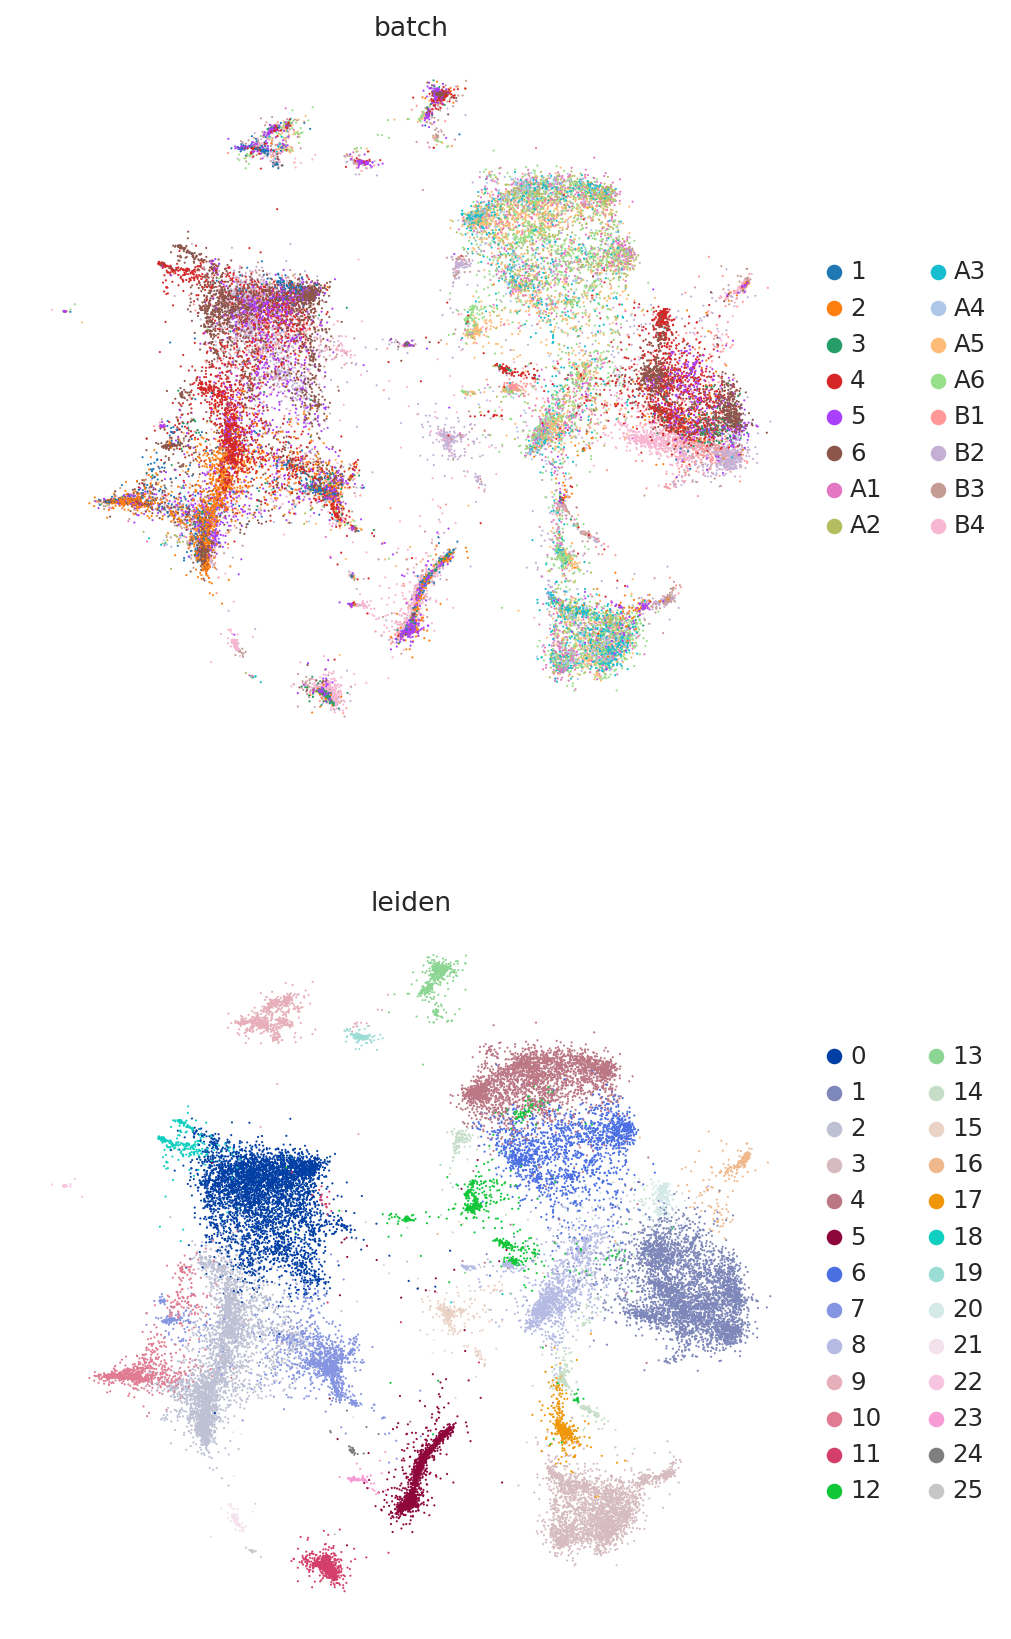

In [13]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["batch", "leiden"],
    frameon=False,
    ncols=1,
)

Because this data has been used for benchmarking, we have access here to curated annotations. We can use those to assess whether the integration worked reasonably well.

/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


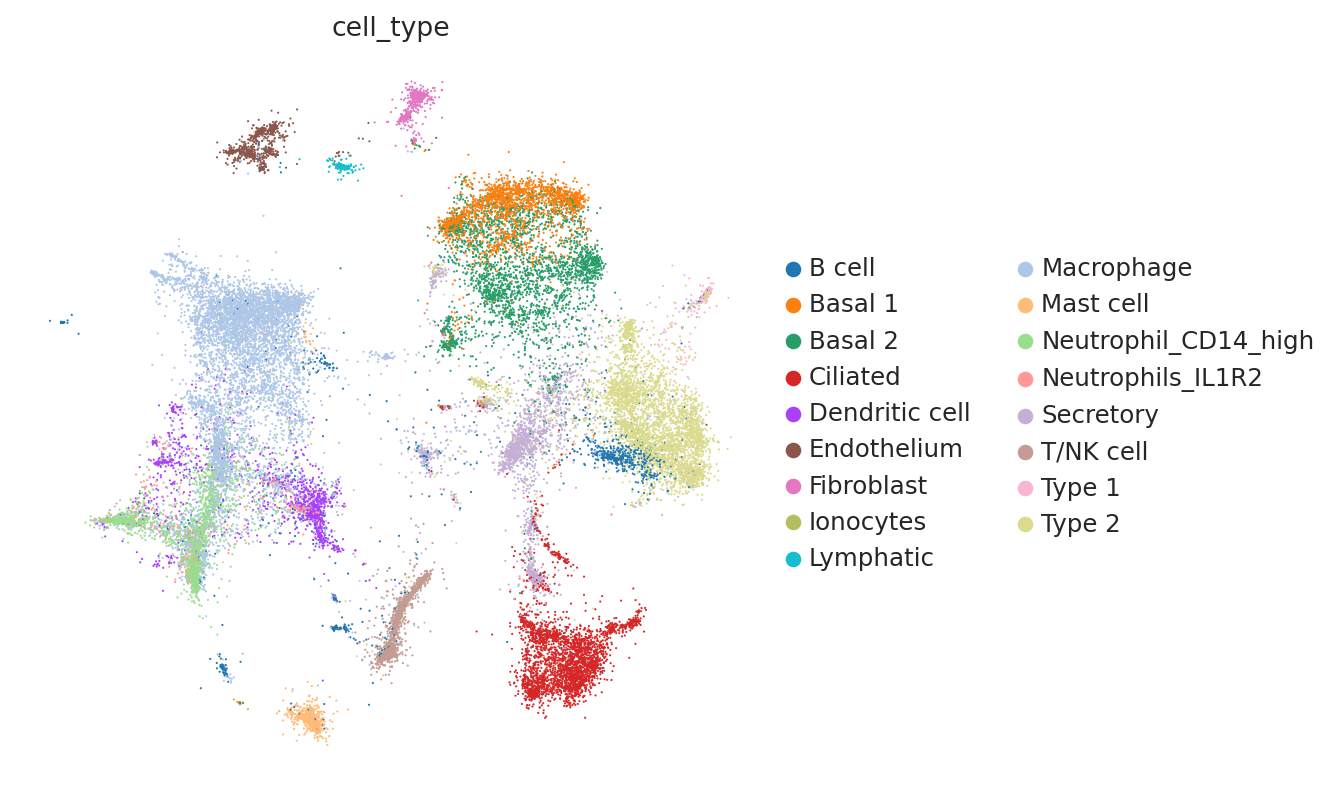

In [14]:
sc.pl.embedding(adata, basis=SCVI_MDE_KEY, color=["cell_type"], frameon=False, ncols=1)

At a quick glance, it looks like the integration worked well. Indeed, the two datasets are relatively mixed in latent space and the cell types cluster together. We see that this dataset is quite complex, where only some batches contain certain cell types.

Below we quantify the performance.

## Integration with scANVI

Previously, we used scVI as we assumed we did not have any cell type annotations available to guide us. Consequently, after the previous analysis, one would have to annotate clusters using differential expression, or by other means.

Now, we assume that all of our data is annotated. This can lead to a more accurate integration result when using scANVI, i.e., our latent data manifold is better suited to downstream tasks like visualization, trajectory inference, or nearest-neighbor-based tasks. scANVI requires:

- the sample identifier for each cell (as in scVI)
- the cell type/state for each cell

scANVI can also be used for label transfer and we recommend checking out the other scANVI tutorials to see explore this functionality.

Since we've already trained an scVI model on our data, we will use it to initialize scANVI.  When initializing scANVI, we provide it the `labels_key`. As scANVI can also be used for datasets with partially-observed annotations, we need to give it the name of the category that corresponds to unlabeled cells. As we have no unlabeled cells, we can give it any random name that is not the name of an exisiting cell type.

```{important}
scANVI should be initialized from a scVI model pre-trained on the same exact data.
```

In [15]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    model,
    adata=adata,
    labels_key="cell_type",
    unlabeled_category="Unknown",
)

/env/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [16]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20:   5%|▌         | 1/20 [00:02<00:56,  2.97s/it]

Epoch 1/20:   5%|▌         | 1/20 [00:02<00:56,  2.97s/it, v_num=1, train_loss_step=562, train_loss_epoch=575]

Epoch 2/20:   5%|▌         | 1/20 [00:02<00:56,  2.97s/it, v_num=1, train_loss_step=562, train_loss_epoch=575]

Epoch 2/20:  10%|█         | 2/20 [00:05<00:53,  2.97s/it, v_num=1, train_loss_step=562, train_loss_epoch=575]

Epoch 2/20:  10%|█         | 2/20 [00:05<00:53,  2.97s/it, v_num=1, train_loss_step=489, train_loss_epoch=543]

Epoch 3/20:  10%|█         | 2/20 [00:05<00:53,  2.97s/it, v_num=1, train_loss_step=489, train_loss_epoch=543]

Epoch 3/20:  15%|█▌        | 3/20 [00:08<00:50,  2.96s/it, v_num=1, train_loss_step=489, train_loss_epoch=543]

Epoch 3/20:  15%|█▌        | 3/20 [00:08<00:50,  2.96s/it, v_num=1, train_loss_step=459, train_loss_epoch=539]

Epoch 4/20:  15%|█▌        | 3/20 [00:08<00:50,  2.96s/it, v_num=1, train_loss_step=459, train_loss_epoch=539]

Epoch 4/20:  20%|██        | 4/20 [00:11<00:47,  2.96s/it, v_num=1, train_loss_step=459, train_loss_epoch=539]

Epoch 4/20:  20%|██        | 4/20 [00:11<00:47,  2.96s/it, v_num=1, train_loss_step=556, train_loss_epoch=537]

Epoch 5/20:  20%|██        | 4/20 [00:11<00:47,  2.96s/it, v_num=1, train_loss_step=556, train_loss_epoch=537]

Epoch 5/20:  25%|██▌       | 5/20 [00:14<00:44,  2.96s/it, v_num=1, train_loss_step=556, train_loss_epoch=537]

Epoch 5/20:  25%|██▌       | 5/20 [00:14<00:44,  2.96s/it, v_num=1, train_loss_step=536, train_loss_epoch=536]

Epoch 6/20:  25%|██▌       | 5/20 [00:14<00:44,  2.96s/it, v_num=1, train_loss_step=536, train_loss_epoch=536]

Epoch 6/20:  30%|███       | 6/20 [00:17<00:41,  2.96s/it, v_num=1, train_loss_step=536, train_loss_epoch=536]

Epoch 6/20:  30%|███       | 6/20 [00:17<00:41,  2.96s/it, v_num=1, train_loss_step=575, train_loss_epoch=536]

Epoch 7/20:  30%|███       | 6/20 [00:17<00:41,  2.96s/it, v_num=1, train_loss_step=575, train_loss_epoch=536]

Epoch 7/20:  35%|███▌      | 7/20 [00:20<00:38,  2.97s/it, v_num=1, train_loss_step=575, train_loss_epoch=536]

Epoch 7/20:  35%|███▌      | 7/20 [00:20<00:38,  2.97s/it, v_num=1, train_loss_step=529, train_loss_epoch=535]

Epoch 8/20:  35%|███▌      | 7/20 [00:20<00:38,  2.97s/it, v_num=1, train_loss_step=529, train_loss_epoch=535]

Epoch 8/20:  40%|████      | 8/20 [00:23<00:35,  2.96s/it, v_num=1, train_loss_step=529, train_loss_epoch=535]

Epoch 8/20:  40%|████      | 8/20 [00:23<00:35,  2.96s/it, v_num=1, train_loss_step=531, train_loss_epoch=535]

Epoch 9/20:  40%|████      | 8/20 [00:23<00:35,  2.96s/it, v_num=1, train_loss_step=531, train_loss_epoch=535]

Epoch 9/20:  45%|████▌     | 9/20 [00:26<00:32,  2.96s/it, v_num=1, train_loss_step=531, train_loss_epoch=535]

Epoch 9/20:  45%|████▌     | 9/20 [00:26<00:32,  2.96s/it, v_num=1, train_loss_step=559, train_loss_epoch=535]

Epoch 10/20:  45%|████▌     | 9/20 [00:26<00:32,  2.96s/it, v_num=1, train_loss_step=559, train_loss_epoch=535]

Epoch 10/20:  50%|█████     | 10/20 [00:29<00:29,  2.96s/it, v_num=1, train_loss_step=559, train_loss_epoch=535]

Epoch 10/20:  50%|█████     | 10/20 [00:29<00:29,  2.96s/it, v_num=1, train_loss_step=583, train_loss_epoch=534]

Epoch 11/20:  50%|█████     | 10/20 [00:29<00:29,  2.96s/it, v_num=1, train_loss_step=583, train_loss_epoch=534]

Epoch 11/20:  55%|█████▌    | 11/20 [00:32<00:26,  2.96s/it, v_num=1, train_loss_step=583, train_loss_epoch=534]

Epoch 11/20:  55%|█████▌    | 11/20 [00:32<00:26,  2.96s/it, v_num=1, train_loss_step=513, train_loss_epoch=534]

Epoch 12/20:  55%|█████▌    | 11/20 [00:32<00:26,  2.96s/it, v_num=1, train_loss_step=513, train_loss_epoch=534]

Epoch 12/20:  60%|██████    | 12/20 [00:35<00:23,  2.97s/it, v_num=1, train_loss_step=513, train_loss_epoch=534]

Epoch 12/20:  60%|██████    | 12/20 [00:35<00:23,  2.97s/it, v_num=1, train_loss_step=503, train_loss_epoch=534]

Epoch 13/20:  60%|██████    | 12/20 [00:35<00:23,  2.97s/it, v_num=1, train_loss_step=503, train_loss_epoch=534]

Epoch 13/20:  65%|██████▌   | 13/20 [00:38<00:20,  2.97s/it, v_num=1, train_loss_step=503, train_loss_epoch=534]

Epoch 13/20:  65%|██████▌   | 13/20 [00:38<00:20,  2.97s/it, v_num=1, train_loss_step=580, train_loss_epoch=534]

Epoch 14/20:  65%|██████▌   | 13/20 [00:38<00:20,  2.97s/it, v_num=1, train_loss_step=580, train_loss_epoch=534]

Epoch 14/20:  70%|███████   | 14/20 [00:41<00:17,  2.96s/it, v_num=1, train_loss_step=580, train_loss_epoch=534]

Epoch 14/20:  70%|███████   | 14/20 [00:41<00:17,  2.96s/it, v_num=1, train_loss_step=564, train_loss_epoch=534]

Epoch 15/20:  70%|███████   | 14/20 [00:41<00:17,  2.96s/it, v_num=1, train_loss_step=564, train_loss_epoch=534]

Epoch 15/20:  75%|███████▌  | 15/20 [00:44<00:14,  2.96s/it, v_num=1, train_loss_step=564, train_loss_epoch=534]

Epoch 15/20:  75%|███████▌  | 15/20 [00:44<00:14,  2.96s/it, v_num=1, train_loss_step=558, train_loss_epoch=534]

Epoch 16/20:  75%|███████▌  | 15/20 [00:44<00:14,  2.96s/it, v_num=1, train_loss_step=558, train_loss_epoch=534]

Epoch 16/20:  80%|████████  | 16/20 [00:47<00:11,  2.96s/it, v_num=1, train_loss_step=558, train_loss_epoch=534]

Epoch 16/20:  80%|████████  | 16/20 [00:47<00:11,  2.96s/it, v_num=1, train_loss_step=501, train_loss_epoch=534]

Epoch 17/20:  80%|████████  | 16/20 [00:47<00:11,  2.96s/it, v_num=1, train_loss_step=501, train_loss_epoch=534]

Epoch 17/20:  85%|████████▌ | 17/20 [00:50<00:08,  2.98s/it, v_num=1, train_loss_step=501, train_loss_epoch=534]

Epoch 17/20:  85%|████████▌ | 17/20 [00:50<00:08,  2.98s/it, v_num=1, train_loss_step=523, train_loss_epoch=534]

Epoch 18/20:  85%|████████▌ | 17/20 [00:50<00:08,  2.98s/it, v_num=1, train_loss_step=523, train_loss_epoch=534]

Epoch 18/20:  90%|█████████ | 18/20 [00:53<00:06,  3.07s/it, v_num=1, train_loss_step=523, train_loss_epoch=534]

Epoch 18/20:  90%|█████████ | 18/20 [00:53<00:06,  3.07s/it, v_num=1, train_loss_step=588, train_loss_epoch=534]

Epoch 19/20:  90%|█████████ | 18/20 [00:53<00:06,  3.07s/it, v_num=1, train_loss_step=588, train_loss_epoch=534]

Epoch 19/20:  95%|█████████▌| 19/20 [00:57<00:03,  3.20s/it, v_num=1, train_loss_step=588, train_loss_epoch=534]

Epoch 19/20:  95%|█████████▌| 19/20 [00:57<00:03,  3.20s/it, v_num=1, train_loss_step=596, train_loss_epoch=534]

Epoch 20/20:  95%|█████████▌| 19/20 [00:57<00:03,  3.20s/it, v_num=1, train_loss_step=596, train_loss_epoch=534]

Epoch 20/20: 100%|██████████| 20/20 [01:00<00:00,  3.25s/it, v_num=1, train_loss_step=596, train_loss_epoch=534]

Epoch 20/20: 100%|██████████| 20/20 [01:00<00:00,  3.25s/it, v_num=1, train_loss_step=506, train_loss_epoch=534]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [01:00<00:00,  3.03s/it, v_num=1, train_loss_step=506, train_loss_epoch=534]

Now we can retrieve the latent space

In [17]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

Again, we may visualize the latent space as well as the inferred labels

In [18]:
SCANVI_MDE_KEY = "X_scANVI_MDE"
adata.obsm[SCANVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCANVI_LATENT_KEY], accelerator="cpu")

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


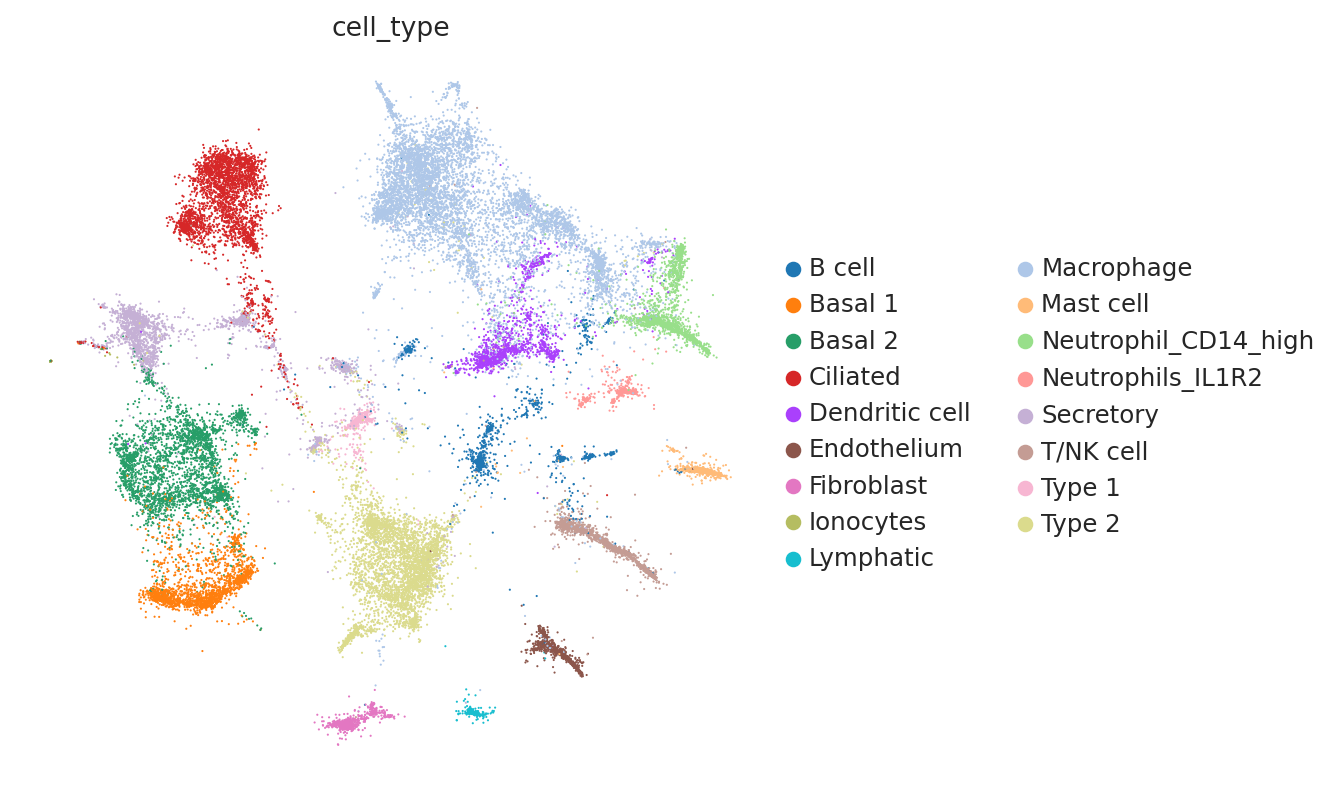

In [19]:
sc.pl.embedding(adata, basis=SCANVI_MDE_KEY, color=["cell_type"], ncols=1, frameon=False)

### Compute integration metrics

Here we use the [scib-metrics](https://scib-metrics.readthedocs.io/en/stable/) package, which contains scalable implementations of the metrics used in the scIB benchmarking suite. We can use these metrics to assess the quality of the integration.

We can see that the additional training with label information and scANVI improved the metrics that capture bio conservation (`cLISI, Silhouette labels`) without sacrificing too much batch correction power (`iLISI, Silhouette batch`)

In [20]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY],
    n_jobs=-1,
)
bm.benchmark()

Computing neighbors:   0%|          | 0/3 [00:00<?, ?it/s]

Computing neighbors:  33%|███▎      | 1/3 [00:05<00:11,  5.61s/it]

Computing neighbors:  67%|██████▋   | 2/3 [00:10<00:05,  5.01s/it]

Computing neighbors: 100%|██████████| 3/3 [00:15<00:00,  4.98s/it]

Computing neighbors: 100%|██████████| 3/3 [00:15<00:00,  5.05s/it]

Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:01<00:16,  1.88s/it, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:01<00:16,  1.88s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:03<00:12,  1.59s/it, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:03<00:12,  1.59s/it, Bio conservation: silhouette_label]             

Metrics:  30%|███       | 3/10 [00:03<00:08,  1.16s/it, Bio conservation: silhouette_label]

Metrics:  30%|███       | 3/10 [00:03<00:08,  1.16s/it, Bio conservation: clisi_knn]       

Metrics:  40%|████      | 4/10 [00:04<00:06,  1.11s/it, Bio conservation: clisi_knn]

Metrics:  40%|████      | 4/10 [00:04<00:06,  1.11s/it, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [00:19<00:29,  5.96s/it, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [00:19<00:29,  5.96s/it, Batch correction: ilisi_knn]       

Metrics:  60%|██████    | 6/10 [00:19<00:15,  3.99s/it, Batch correction: ilisi_knn]

Metrics:  60%|██████    | 6/10 [00:19<00:15,  3.99s/it, Batch correction: kbet_per_label]

/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Metrics:  70%|███████   | 7/10 [00:38<00:26,  8.72s/it, Batch correction: kbet_per_label]

Metrics:  70%|███████   | 7/10 [00:38<00:26,  8.72s/it, Batch correction: graph_connectivity]

/env/lib/python3.11/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)



Metrics:  80%|████████  | 8/10 [00:38<00:17,  8.72s/it, Batch correction: pcr_comparison]    

Metrics:  90%|█████████ | 9/10 [00:38<00:04,  4.64s/it, Batch correction: pcr_comparison]

Embeddings:  33%|███▎      | 1/3 [00:38<01:17, 38.66s/it]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:00<00:04,  1.81it/s, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:00<00:04,  1.81it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:01<00:06,  1.21it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:01<00:06,  1.21it/s, Bio conservation: silhouette_label]             

Metrics:  30%|███       | 3/10 [00:02<00:04,  1.54it/s, Bio conservation: silhouette_label]

Metrics:  30%|███       | 3/10 [00:02<00:04,  1.54it/s, Bio conservation: clisi_knn]       

Metrics:  40%|████      | 4/10 [00:02<00:03,  1.54it/s, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [00:04<00:04,  1.10it/s, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [00:04<00:04,  1.10it/s, Batch correction: ilisi_knn]       

Metrics:  60%|██████    | 6/10 [00:04<00:03,  1.10it/s, Batch correction: kbet_per_label]

/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Metrics:  70%|███████   | 7/10 [00:19<00:11,  3.94s/it, Batch correction: kbet_per_label]

Metrics:  70%|███████   | 7/10 [00:19<00:11,  3.94s/it, Batch correction: graph_connectivity]

/env/lib/python3.11/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)



Metrics:  80%|████████  | 8/10 [00:19<00:07,  3.94s/it, Batch correction: pcr_comparison]    

Metrics:  90%|█████████ | 9/10 [00:19<00:02,  2.47s/it, Batch correction: pcr_comparison]

Embeddings:  67%|██████▋   | 2/3 [00:58<00:27, 27.66s/it]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s]

Metrics:   0%|          | 0/10 [00:00<?, ?it/s, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:00<00:04,  2.20it/s, Bio conservation: isolated_labels]

Metrics:  10%|█         | 1/10 [00:00<00:04,  2.20it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:01<00:04,  1.70it/s, Bio conservation: nmi_ari_cluster_labels_kmeans]

Metrics:  20%|██        | 2/10 [00:01<00:04,  1.70it/s, Bio conservation: silhouette_label]             

Metrics:  30%|███       | 3/10 [00:01<00:03,  1.92it/s, Bio conservation: silhouette_label]

Metrics:  30%|███       | 3/10 [00:01<00:03,  1.92it/s, Bio conservation: clisi_knn]       

Metrics:  40%|████      | 4/10 [00:01<00:03,  1.92it/s, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [00:01<00:01,  3.78it/s, Batch correction: silhouette_batch]

Metrics:  50%|█████     | 5/10 [00:01<00:01,  3.78it/s, Batch correction: ilisi_knn]       

Metrics:  60%|██████    | 6/10 [00:01<00:01,  3.78it/s, Batch correction: kbet_per_label]

/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


/env/lib/python3.11/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


Metrics:  70%|███████   | 7/10 [00:15<00:09,  3.28s/it, Batch correction: kbet_per_label]

Metrics:  70%|███████   | 7/10 [00:15<00:09,  3.28s/it, Batch correction: graph_connectivity]

/env/lib/python3.11/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)



Metrics:  80%|████████  | 8/10 [00:15<00:06,  3.28s/it, Batch correction: pcr_comparison]    

Embeddings: 100%|██████████| 3/3 [01:14<00:00, 22.24s/it]

Embeddings: 100%|██████████| 3/3 [01:14<00:00, 24.80s/it]

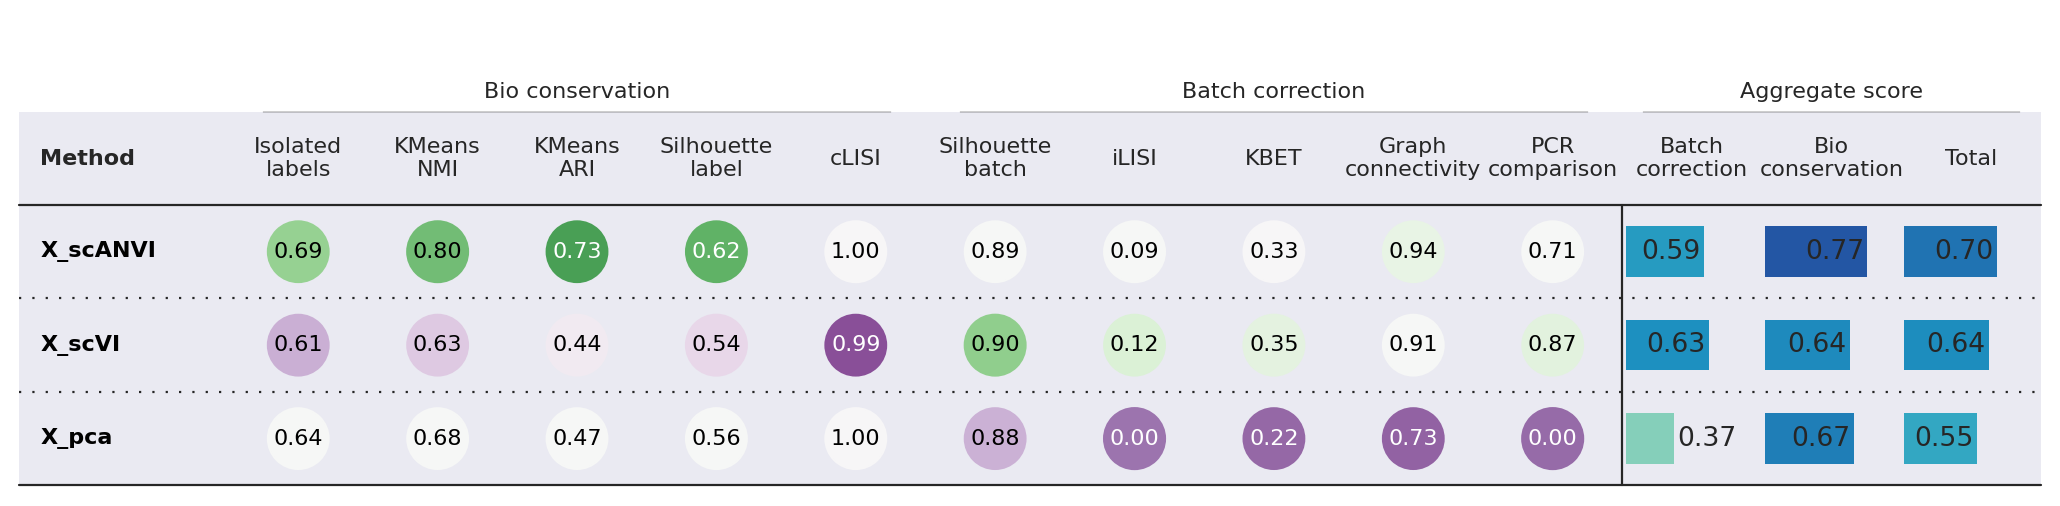

In [21]:
bm.plot_results_table(min_max_scale=False)

In [22]:
df = bm.get_results(min_max_scale=False)
print(df)

Isolated labels        KMeans NMI        KMeans ARI  \
Embedding                                                           
X_pca                 0.64364          0.681808          0.470352   
X_scVI               0.607581          0.625488           0.44097   
X_scANVI             0.687845          0.804745          0.732296   
Metric Type  Bio conservation  Bio conservation  Bio conservation   

             Silhouette label             cLISI  Silhouette batch  \
Embedding                                                           
X_pca                0.557418               1.0          0.878176   
X_scVI               0.536606          0.993054          0.895216   
X_scANVI             0.624912               1.0          0.885531   
Metric Type  Bio conservation  Bio conservation  Batch correction   

                        iLISI              KBET Graph connectivity  \
Embedding                                                            
X_pca                0.003445          0.223596           0.728504   
X_scVI               0.117146           0.34879           0.910749   
X_scANVI             0.089942          0.327317           0.939452   
Metric Type  Batch correction  Batch correction   Batch correction   

               PCR comparison Batch correction Bio conservation  \
Embedding                                                         
X_pca                     0.0         0.366744         0.670644   
X_scVI               0.868805         0.628141          0.64074   
X_scANVI             0.711203         0.590689         0.769959   
Metric Type  Batch correction  Aggregate score  Aggregate score   

                       Total  
Embedding                     
X_pca               0.549084  
X_scVI                0.6357  
X_scANVI            0.698251  
Metric Type  Aggregate score